# Final Project Jupyter Book 
## 18 March 2024 
### Ana M. Stringer
This Jupyterbook uses ICESat-2 monthly gridded sea ice thickness data to investigate how sea ice thickness over critical hunting areas near Kivalina has changed since 2018. 
The second part of this Jupyterbook investigates the important parameter of wind speed, which also impacts sea ice usage and safety.
Lastly, this Jupyterbook utilizes the package streamlit to compile findings and present them in an interactive format. 

## Part 0: Import and Set-Up

In [ ]:
import xarray as xr 
import numpy as np
import holoviews as hv
import pandas as pd
import hvplot.pandas 
import hvplot.xarray
import matplotlib as mpl
import warnings
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import streamlit as st
import geoviews as gv
gv.extension('bokeh')
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, CheckboxGroup, CustomJS, HoverTool
from bokeh.layouts import column

from utils.read_data_utils import read_IS2SITMOGR4
from utils.plotting_utils import (
    static_winter_comparison_lineplot, staticArcticMaps,
    staticArcticMaps_overlayDrifts, interactiveArcticMaps,
    compute_gridcell_winter_means, interactive_winter_comparison_lineplot
)

# Helper functions for reading the data from the bucket and plotting
from utils.read_data_utils import read_IS2SITMOGR4, read_book_data
from utils.plotting_utils import static_winter_comparison_lineplot, staticArcticMaps, interactiveArcticMaps, compute_gridcell_winter_means, interactive_winter_comparison_lineplot, compute_gridcell_winter_means # Plotting utils 

# Plotting dependencies
#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
# Sets figure size in the notebook
mpl.rcParams['figure.dpi'] = 300 

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 

### Site Map of Kivalina, AK 
##### Kivalina, Alaska is a traditional Iñupiaq subsistence village located in Northwestern Alaska. The village is situated on a narrow barrier island, making it particularly vulnerable to the impacts of climate change.

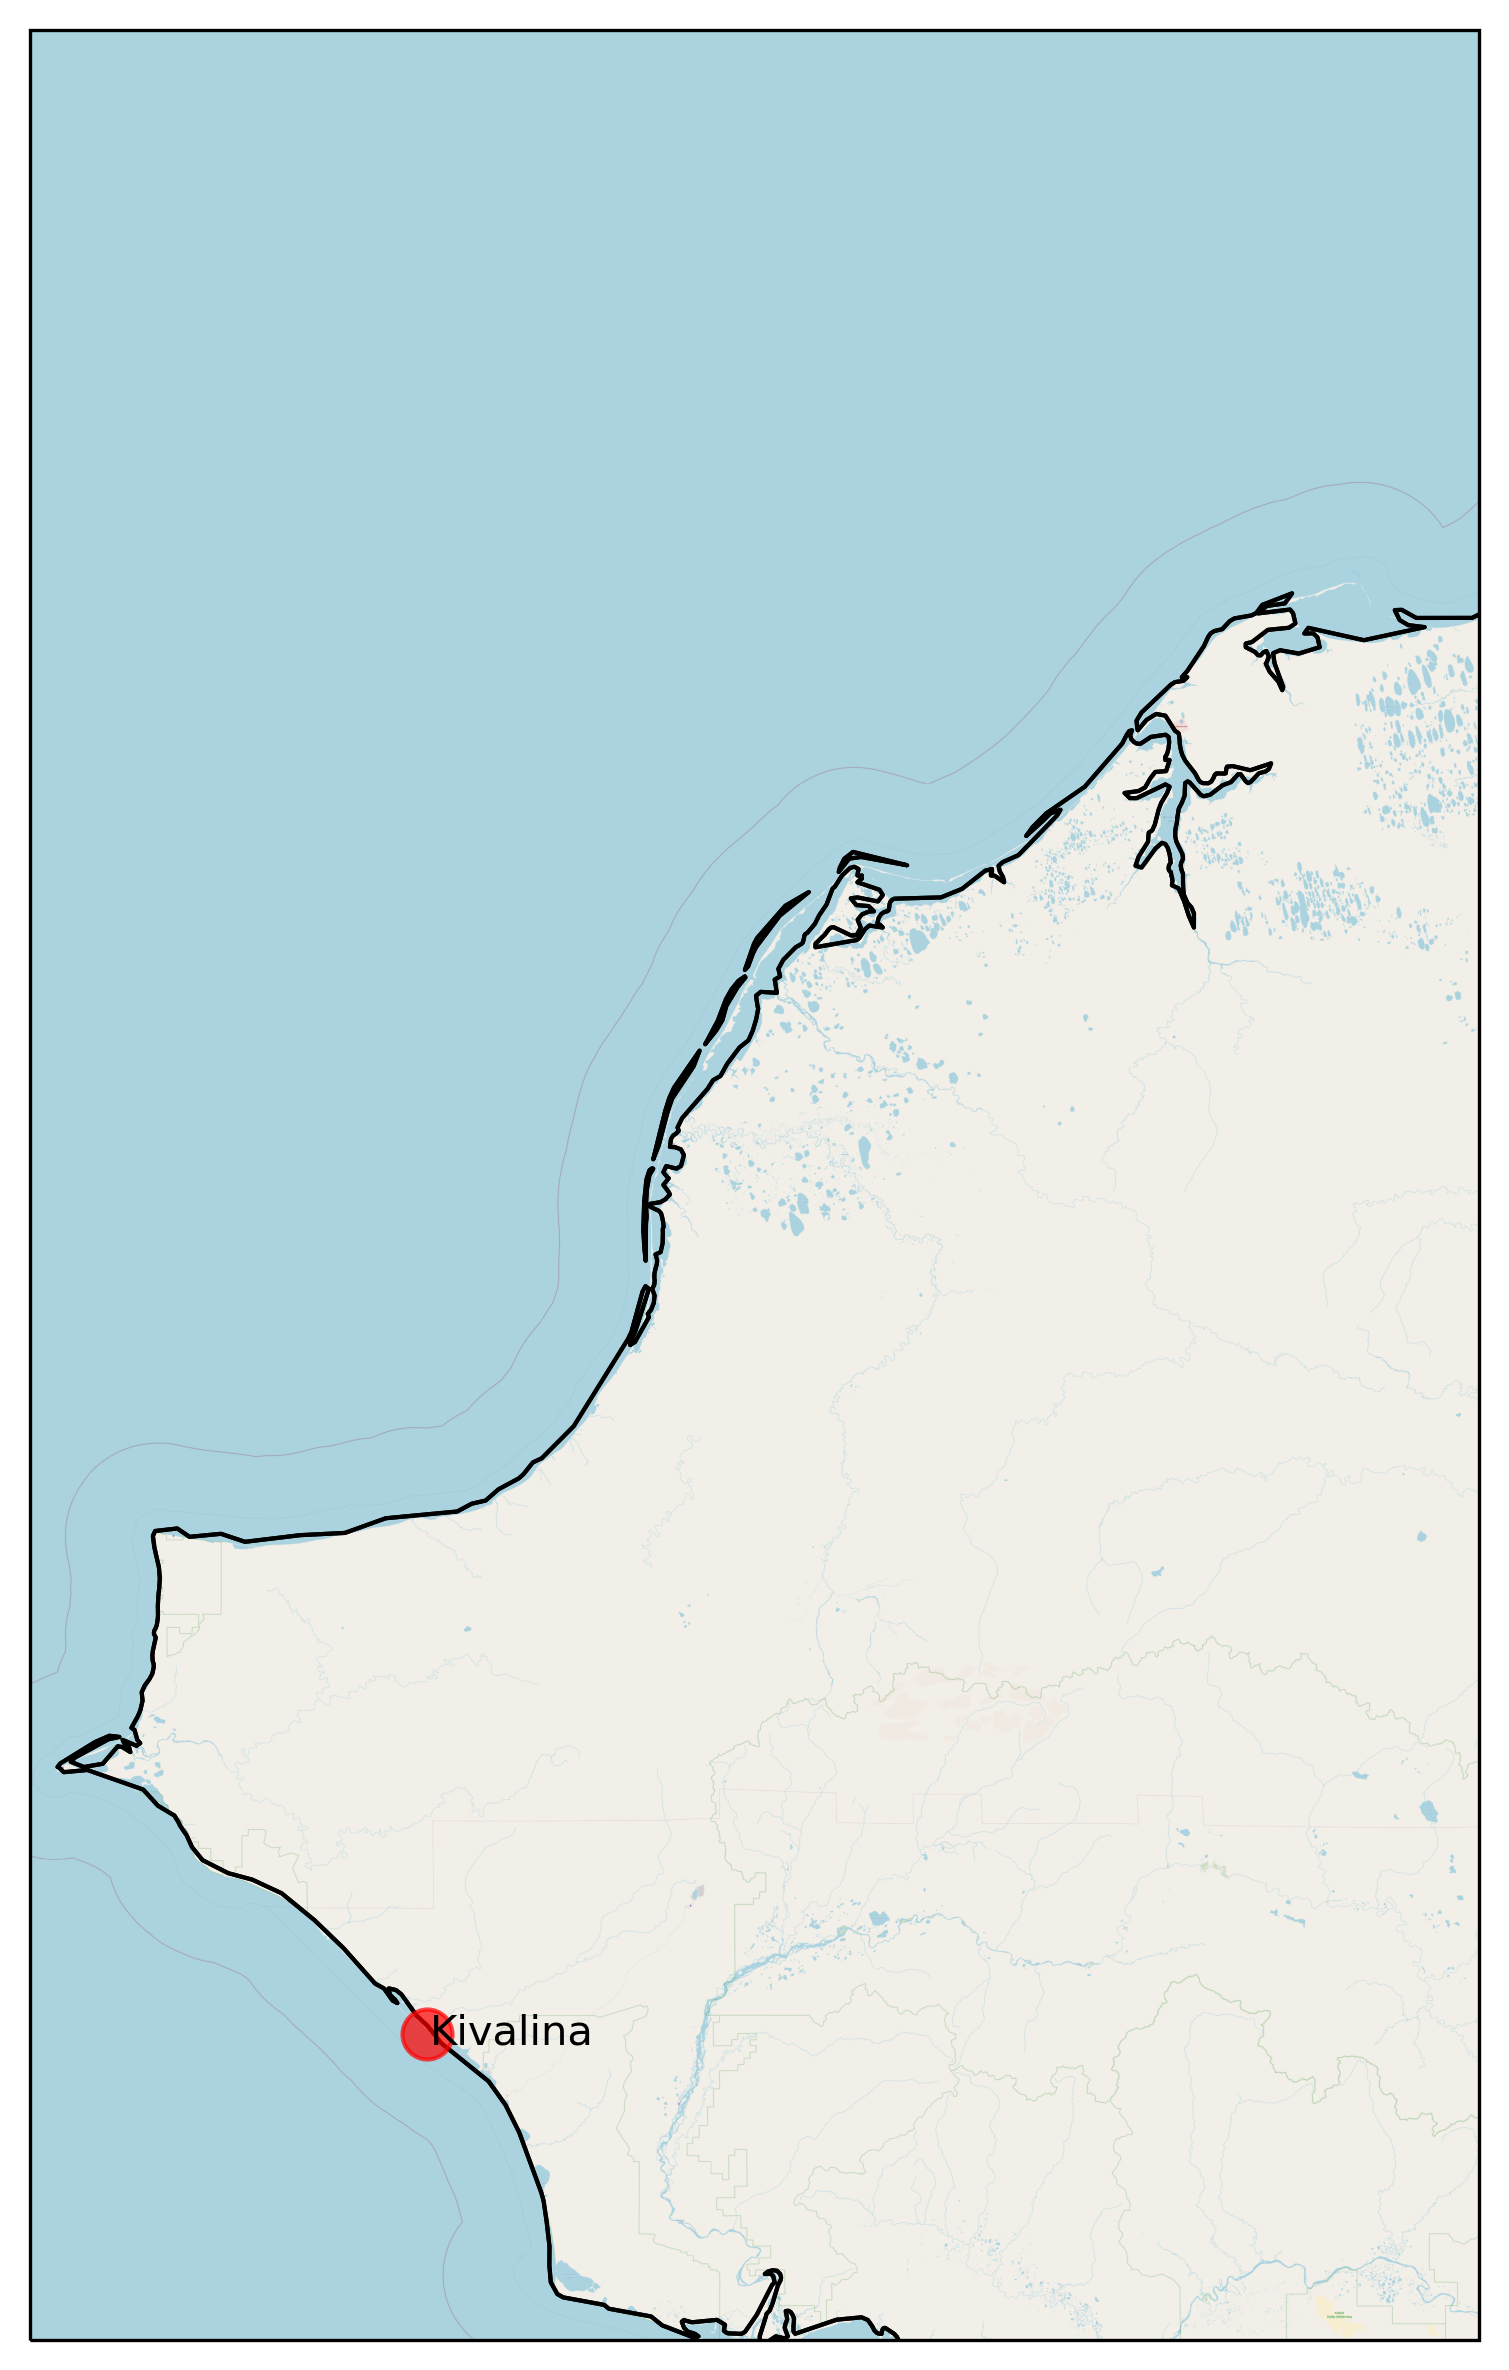

In [7]:
terrain_background = cimgt.OSM()
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt

# Coordinates for Kivalina, AK
kivalina_lon, kivalina_lat = -164.5338, 67.7319

terrain_background = cimgt.OSM()
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=terrain_background.crs).
ax.set_extent([-167, -158, 67, 72], crs=ccrs.Geodetic())

ax.add_image(terrain_background, 10)
ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), edgecolor='black')
ax.plot(kivalina_lon, kivalina_lat, marker='o', color='red', markersize=12, alpha=0.7, transform=ccrs.Geodetic())
ax.text(kivalina_lon + 0.02, kivalina_lat, 'Kivalina', verticalalignment='center', transform=ccrs.Geodetic())
plt.show()


In [8]:
# For working with gridded climate data 
import xarray as xr 
# Helper function for reading the data from the bucket
from utils.read_data_utils import read_IS2SITMOGR4 
from utils.plotting_utils import static_winter_comparison_lineplot, staticArcticMaps, staticArcticMaps_overlayDrifts, interactiveArcticMaps, compute_gridcell_winter_means, interactive_winter_comparison_lineplot, compute_gridcell_winter_means # Plotting utils 
import numpy as np
#%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 



In [9]:
#Read in the raw monthly gridded winter Arctic sea ice data from S3
IS2SITMOGR4_all = read_IS2SITMOGR4() 

load zarr from S3 bucket:  icesat-2-sea-ice-us-west-2
zarr_path: s3://icesat-2-sea-ice-us-west-2/IS2SITMOGR4_V3/zarr/IS2SITMOGR4_V3_201811-202304.zarr/all/


In [10]:
IS2SITMOGR4_v3 = read_IS2SITMOGR4(data_type='zarr-s3', 
                                   local_data_path='./data/IS2SITMOGR4/', version='V3', download=False,
                                   persist=True) 

IS2SITMOGR4_v3

load zarr from S3 bucket:  icesat-2-sea-ice-us-west-2
zarr_path: s3://icesat-2-sea-ice-us-west-2/IS2SITMOGR4_V3/zarr/IS2SITMOGR4_V3_201811-202304.zarr/all/


<xarray.Dataset>
Dimensions:                         (time: 38, y: 448, x: 304)
Coordinates:
    latitude                        (y, x) float32 31.1 31.2 ... 34.58 34.47
    longitude                       (y, x) float32 168.3 168.1 ... -10.18 -9.999
  * time                            (time) datetime64[ns] 2018-11-01 ... 2023...
  * x                               (x) float32 -3.838e+06 ... 3.738e+06
  * y                               (y) float32 5.838e+06 ... -5.338e+06
Data variables: (12/27)
    crs                             (time) int32 dask.array<chunksize=(38,), meta=np.ndarray>
    freeboard                       (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    freeboard_int                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_density                     (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_density_j22                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ice_thickness                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    ...                              ...
    snow_density_sm                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_density_w99                (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth                      (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_int                  (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_mw99                 (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
    snow_depth_sm                   (time, y, x) float32 dask.array<chunksize=(1, 448, 304), meta=np.ndarray>
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  November 2018 to April 2023 (zarr xarray dataset) IS2SITMOG...
    history:      Created 04/12/23
    reference:    Official NSIDC data doi: 10.5067/CV6JEXEE31HF. Derived data...

In [11]:
# Years over which to perform analysis
years = [2019,2020,2021,2022,2023]

In [12]:
# recent, open issue with cartography package causing error that can't be resolved in cell below. 

In [ ]:
# Define the latitude and longitude bounds for the region around Kivalina, AK, including Point Hope and Kotzebue to give a zoomed out view
lat_bounds = [66, 71]
lon_bounds = [-167, -162]

import cartopy.crs as ccrs
map_extent = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]

mpl.rcParams['figure.dpi'] = 150
warnings.filterwarnings('ignore')

IS2SITMOGR4_all = read_IS2SITMOGR4()

# Constants for conversion
METERS_TO_FEET = 3.28084

def staticArcticMaps(data, dates, set_cbarlabel, cmap, col_wrap, vmin, vmax, out_str, map_extent=None):
    # Convert vmin and vmax from meters to feet for the colorbar scale
    vmin_feet = vmin * METERS_TO_FEET
    vmax_feet = vmax * METERS_TO_FEET

    p = data.plot(x="longitude", y="latitude", 
                  col="time", 
                  col_wrap=col_wrap, 
                  vmin=vmin_feet,  # Use the converted min value
                  vmax=vmax_feet,  # Use the converted max value
                  cmap=cmap,
                  subplot_kws={'projection': ccrs.NorthPolarStereo(central_longitude=-155)}, 
                  transform=ccrs.PlateCarree())

    for ax in p.axes.flat:
        ax.coastlines()
        if map_extent:
            ax.set_extent(map_extent, ccrs.PlateCarree())
    p.cbar.set_label(set_cbarlabel)

    plt.suptitle(set_cbarlabel)
    plt.show()

# latitude and longitude bounds for the region around Kivalina, AK
lat_bounds = [66, 71]
lon_bounds = [-167, -162]

# Compute the winter means for the entire dataset
years = [2019,2020, 2021, 2022, 2023]
thickness_winter_means = compute_gridcell_winter_means(IS2SITMOGR4_all.ice_thickness_int, years=years)

# Plot the data, focusing on the region of interest
map_extent = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]

# Convert the sea ice thickness data from meters to feet before plotting
thickness_winter_means_in_feet = thickness_winter_means * METERS_TO_FEET

staticArcticMaps(thickness_winter_means_in_feet, 
                 dates=thickness_winter_means_in_feet.time.values, 
                 set_cbarlabel="Sea ice thickness (ft)",  # Updated label
                 cmap="viridis", 
                 col_wrap=4, 
                 vmin=0,  # Minimum value in feet, which remains 0
                 vmax=0.8,  # Maximum value in meters, which will be converted inside the function
                 out_str='thickness_winter_region_2018_2023',
                 map_extent=map_extent)



# Part 1: Assess Sea Ice Thickness Gridcell Values 
### From earlier interviews conducted in my thesis research, we found that users of sea ice for hunting and platform purposes takes place approximate 10 miles out (west) from the coastline of Kivalina. Thus, the gridcell closest to Kivalina was selected to assess first for changes over time in the form of a simple line graph. The months of January - April were selected as, historically,these capture the months when bowhead whales migrate near Kivalina. 

In [8]:
# # January Ice Thickness - 10 miles west from Kivalina 
# import numpy as np
# import xarray as xr

# # Define the conversion factor from meters to feet
# METERS_TO_FEET = 3.28084

# # Kivalina coordinates
# kivalina_longitude = -164.5636
# kivalina_latitude = 67.7316
# MILES_TO_DEGREES_LONG = 1 / (np.cos(np.radians(kivalina_latitude)) * 69)
# longitude_10m_west = kivalina_longitude - (10 * MILES_TO_DEGREES_LONG)

# # function to find the index of the grid cell that is closest to a given latitude and longitude
# def find_nearest_grid_cell(latitudes, longitudes, lat_point, lon_point):
#     absolute_diff_lat = np.abs(latitudes - lat_point)
#     absolute_diff_lon = np.abs(longitudes - lon_point)
#     distance = np.sqrt(absolute_diff_lat**2 + absolute_diff_lon**2)
#     return np.unravel_index(np.argmin(distance, axis=None), distance.shape)

# latitudes = IS2SITMOGR4_all['latitude'].values
# longitudes = IS2SITMOGR4_all['longitude'].values
# nearest_y, nearest_x = find_nearest_grid_cell(latitudes, longitudes, kivalina_latitude, longitude_10m_west)
# thickness_values = {}

# for year in range(2019, 2024):
#     january_data = IS2SITMOGR4_all.sel(time=IS2SITMOGR4_all['time'].dt.month == 1)
#     year_data = january_data.sel(time=january_data['time'].dt.year == year)

#     # data check 
#     if year_data.sizes['time'] > 0:
#         sea_ice_thickness_value = year_data.isel(x=nearest_x, y=nearest_y).ice_thickness_int.values * METERS_TO_FEET
#         if np.isnan(sea_ice_thickness_value).all():
#             print(f"No valid data for the grid cell 10 miles west of Kivalina for January {year}.")
#         else:
#             # Calculate the average thickness for January if there are multiple measurements
#             average_thickness = np.nanmean(sea_ice_thickness_value)
#             thickness_values[year] = average_thickness
#             print(f"Average sea ice thickness 10 miles west of Kivalina for January {year}: {average_thickness:.2f} feet")
#     else:
#         print(f"No data available for January {year}.")

# # print out values 
# print("\nSea ice thickness 10 miles west of Kivalina for January (2019-2023):")
# for year, thickness in thickness_values.items():
#     print(f"{year}: {thickness:.2f} feet")


Average sea ice thickness 10 miles west of Kivalina for January 2019: 2.89 feet
Average sea ice thickness 10 miles west of Kivalina for January 2020: 0.84 feet
Average sea ice thickness 10 miles west of Kivalina for January 2021: 0.36 feet
Average sea ice thickness 10 miles west of Kivalina for January 2022: 2.99 feet
No valid data for the grid cell 10 miles west of Kivalina for January 2023.

Sea ice thickness 10 miles west of Kivalina for January (2019-2023):
2019: 2.89 feet
2020: 0.84 feet
2021: 0.36 feet
2022: 2.99 feet


Average sea ice thickness near Kivalina for January 2019: 2.46 feet
Average sea ice thickness near Kivalina for January 2020: 0.66 feet
Average sea ice thickness near Kivalina for January 2021: 0.67 feet
Average sea ice thickness near Kivalina for January 2022: 3.05 feet
Average sea ice thickness near Kivalina for January 2023: 2.54 feet


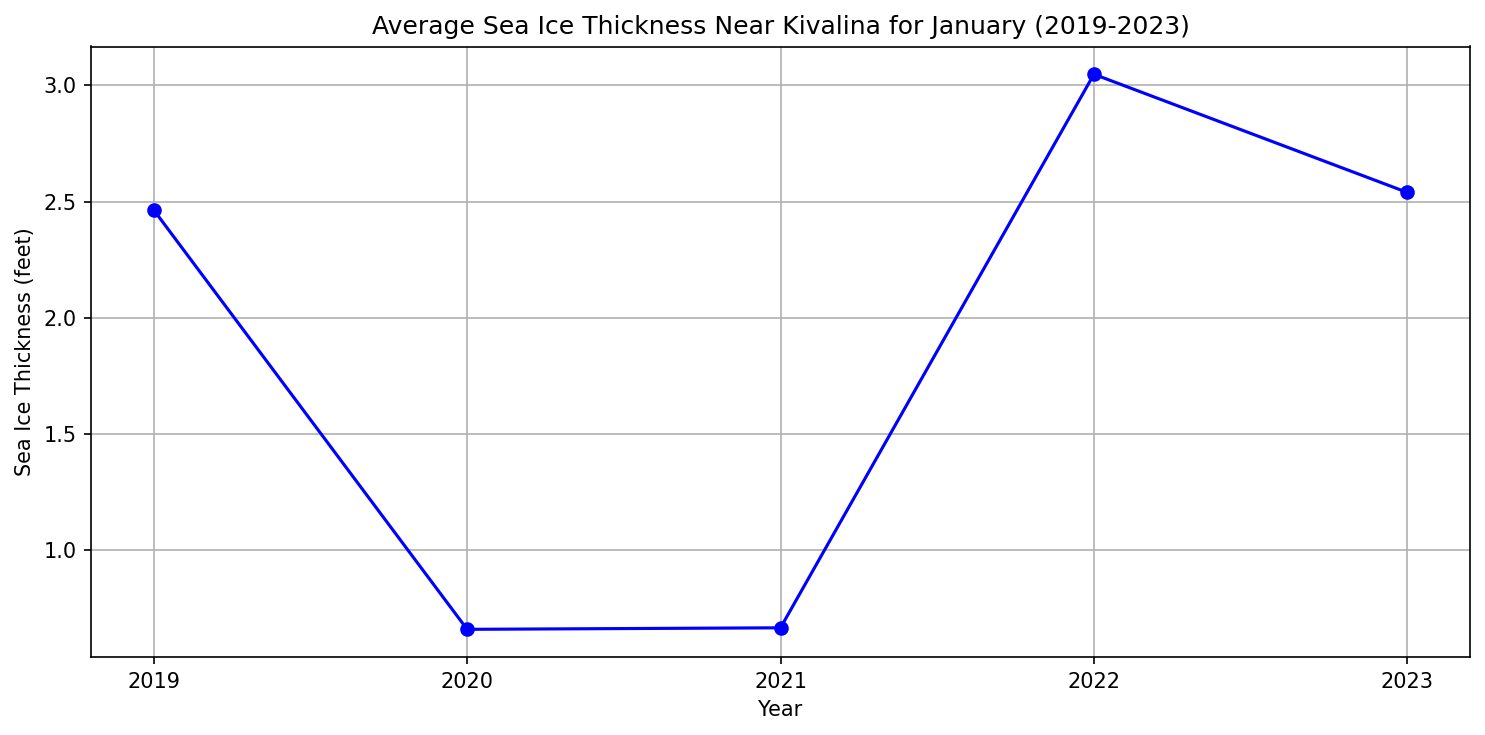

In [9]:
#revising approach to look for two closest gridcells (skipping over closest gridcell if there's no data for that month)
METERS_TO_FEET = 3.28084
# function 
def find_two_closest_grid_cells(latitudes, longitudes, lat_point, lon_point):
    distances = np.sqrt((latitudes - lat_point)**2 + (longitudes - lon_point)**2)
    idx_closest = np.unravel_index(np.argsort(distances, axis=None)[:2], distances.shape)
    return idx_closest

latitudes = IS2SITMOGR4_all['latitude'].values
longitudes = IS2SITMOGR4_all['longitude'].values
idx_closest_cells = find_two_closest_grid_cells(latitudes, longitudes, kivalina_latitude, kivalina_longitude)

years = []
average_thickness_values = []

for year in range(2019, 2024):
    january_data = IS2SITMOGR4_all.sel(time=IS2SITMOGR4_all['time'].dt.month == 1)
    year_data = january_data.sel(time=january_data['time'].dt.year == year)

    if year_data.sizes['time'] > 0:
        # Extract values for the two closest grid cells
        values = year_data.isel(x=xr.DataArray(idx_closest_cells[1], dims="points"), 
                                y=xr.DataArray(idx_closest_cells[0], dims="points")).ice_thickness_int.values
        
        average_thickness = np.nanmean(values) * METERS_TO_FEET
        years.append(year)
        average_thickness_values.append(average_thickness)
        print(f"Average sea ice thickness near Kivalina for January {year}: {average_thickness:.2f} feet")
    else:
        print(f"No data available for January {year}.")

plt.figure(figsize=(10, 5))
plt.plot(years, average_thickness_values, marker='o', linestyle='-', color='blue')
plt.title('Average Sea Ice Thickness Near Kivalina for January (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Sea Ice Thickness (feet)')
plt.grid(True)
plt.xticks(years)  # Ensure only the years in the dataset are used as x-ticks
plt.tight_layout()
plt.show()


Average sea ice thickness near Kivalina for February 2019: 2.19 feet
Average sea ice thickness near Kivalina for February 2020: 3.71 feet
Average sea ice thickness near Kivalina for February 2021: 1.35 feet
Average sea ice thickness near Kivalina for February 2022: 4.99 feet
Average sea ice thickness near Kivalina for February 2023: 2.76 feet


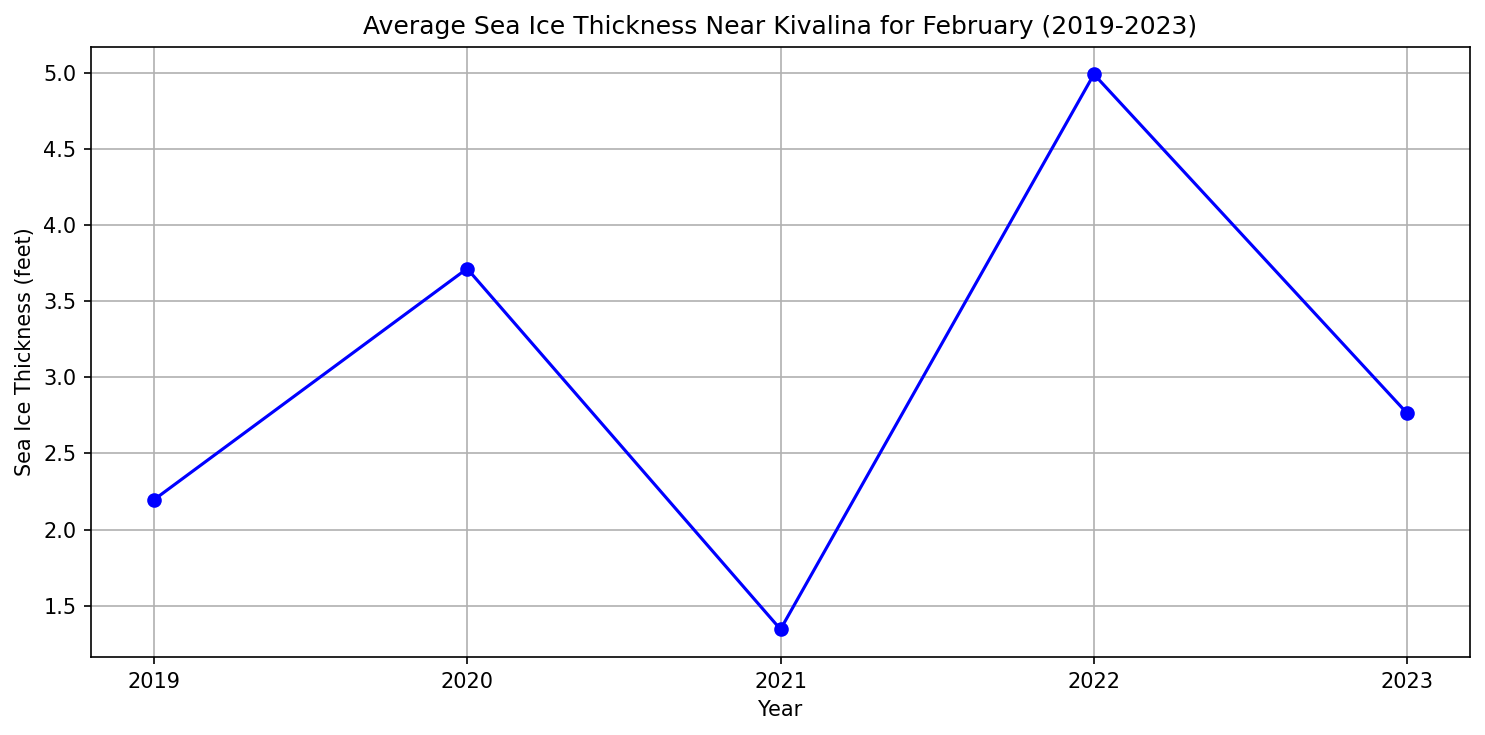

In [10]:
#February Ice Thickness 
def find_two_closest_grid_cells(latitudes, longitudes, lat_point, lon_point):
    distances = np.sqrt((latitudes - lat_point)**2 + (longitudes - lon_point)**2)
    idx_closest = np.unravel_index(np.argsort(distances, axis=None)[:2], distances.shape)
    return idx_closest

idx_closest_cells = find_two_closest_grid_cells(latitudes, longitudes, kivalina_latitude, kivalina_longitude)
years = []
average_thickness_values = []

for year in range(2019, 2024):
    february_data = IS2SITMOGR4_all.sel(time=IS2SITMOGR4_all['time'].dt.month == 2)
    year_data = february_data.sel(time=february_data['time'].dt.year == year)

    if year_data.sizes['time'] > 0:
        # Extract values for the two closest grid cells
        values = year_data.isel(x=xr.DataArray(idx_closest_cells[1], dims="points"), 
                                y=xr.DataArray(idx_closest_cells[0], dims="points")).ice_thickness_int.values
        
        average_thickness = np.nanmean(values) * METERS_TO_FEET
        years.append(year)
        average_thickness_values.append(average_thickness)
        print(f"Average sea ice thickness near Kivalina for February {year}: {average_thickness:.2f} feet")
    else:
        print(f"No data available for February {year}.")

plt.figure(figsize=(10, 5))
plt.plot(years, average_thickness_values, marker='o', linestyle='-', color='blue')
plt.title('Average Sea Ice Thickness Near Kivalina for February (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Sea Ice Thickness (feet)')
plt.grid(True)
plt.xticks(years)  # Ensure only the years in the dataset are used as x-ticks
plt.tight_layout()
plt.show()


Average sea ice thickness near Kivalina for March 2019: 0.75 feet
Average sea ice thickness near Kivalina for March 2020: 2.98 feet
Average sea ice thickness near Kivalina for March 2021: 1.76 feet
Average sea ice thickness near Kivalina for March 2022: 1.04 feet
Average sea ice thickness near Kivalina for March 2023: 5.74 feet


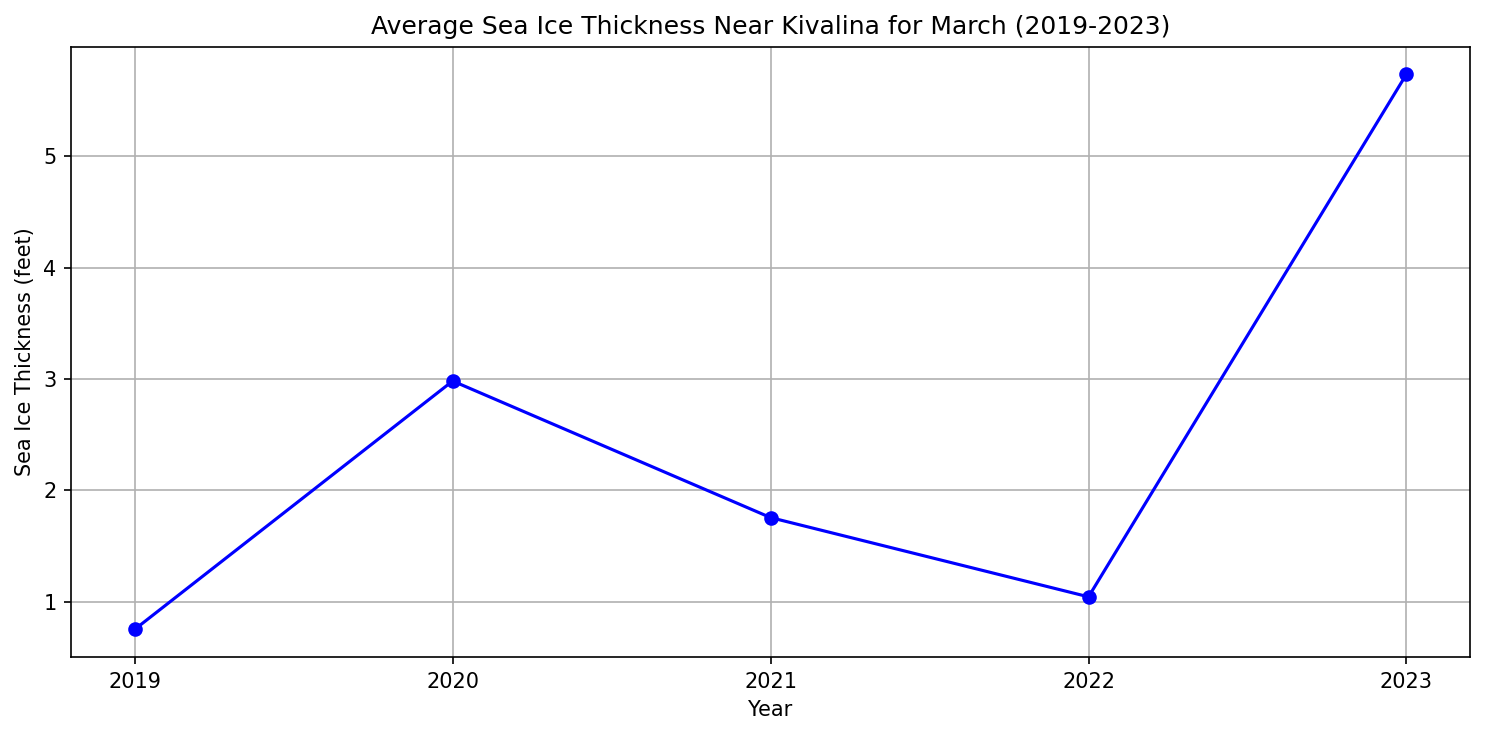

In [91]:
#March Thickness
def find_two_closest_grid_cells(latitudes, longitudes, lat_point, lon_point):
    distances = np.sqrt((latitudes - lat_point)**2 + (longitudes - lon_point)**2)
    
    idx_closest = np.unravel_index(np.argsort(distances, axis=None)[:2], distances.shape)
    return idx_closest

latitudes = IS2SITMOGR4_all['latitude'].values
longitudes = IS2SITMOGR4_all['longitude'].values

idx_closest_cells = find_two_closest_grid_cells(latitudes, longitudes, kivalina_latitude, kivalina_longitude)

years = []
average_thickness_values = []

for year in range(2019, 2024):
    march_data = IS2SITMOGR4_all.sel(time=IS2SITMOGR4_all['time'].dt.month == 3)
    year_data = march_data.sel(time=march_data['time'].dt.year == year)

    if year_data.sizes['time'] > 0:
        values = year_data.isel(x=xr.DataArray(idx_closest_cells[1], dims="points"), 
                                y=xr.DataArray(idx_closest_cells[0], dims="points")).ice_thickness_int.values
        
        average_thickness = np.nanmean(values) * METERS_TO_FEET
        years.append(year)
        average_thickness_values.append(average_thickness)
        print(f"Average sea ice thickness near Kivalina for March {year}: {average_thickness:.2f} feet")
    else:
        print(f"No data available for March {year}.")

plt.figure(figsize=(10, 5))
plt.plot(years, average_thickness_values, marker='o', linestyle='-', color='blue')
plt.title('Average Sea Ice Thickness Near Kivalina for March (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Sea Ice Thickness (feet)')
plt.grid(True)
plt.xticks(years)  
plt.tight_layout()
plt.show()


Average sea ice thickness near Kivalina for April 2019: 1.01 feet
Average sea ice thickness near Kivalina for April 2020: 2.80 feet
Average sea ice thickness near Kivalina for April 2021: 2.82 feet
Average sea ice thickness near Kivalina for April 2022: 1.02 feet
Average sea ice thickness near Kivalina for April 2023: 2.90 feet


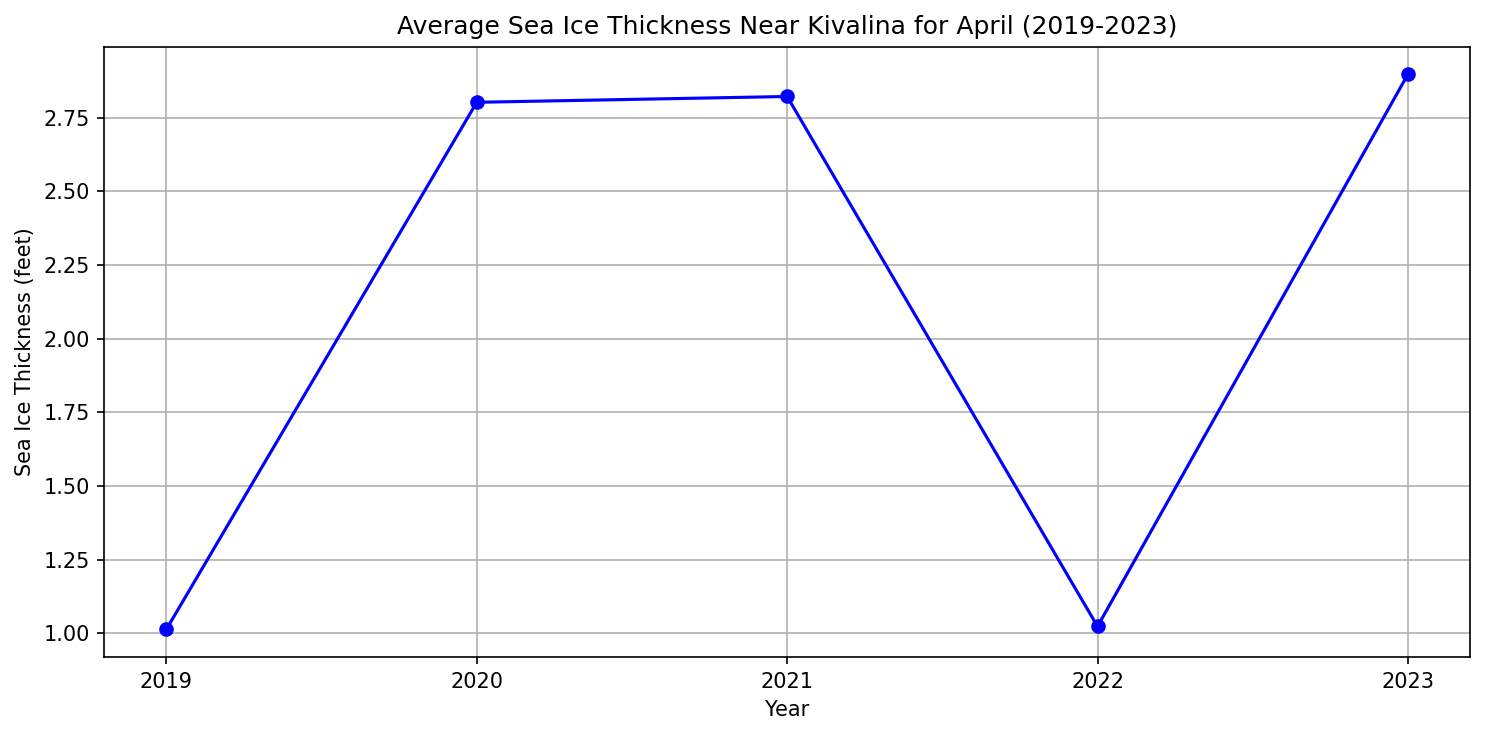

In [11]:
#April Thickness
def find_two_closest_grid_cells(latitudes, longitudes, lat_point, lon_point):
    distances = np.sqrt((latitudes - lat_point)**2 + (longitudes - lon_point)**2)
    idx_closest = np.unravel_index(np.argsort(distances, axis=None)[:2], distances.shape)
    return idx_closest

latitudes = IS2SITMOGR4_all['latitude'].values
longitudes = IS2SITMOGR4_all['longitude'].values

idx_closest_cells = find_two_closest_grid_cells(latitudes, longitudes, kivalina_latitude, kivalina_longitude)

years = []
average_thickness_values = []

for year in range(2019, 2024):
    march_data = IS2SITMOGR4_all.sel(time=IS2SITMOGR4_all['time'].dt.month == 4)
    year_data = march_data.sel(time=march_data['time'].dt.year == year)

    if year_data.sizes['time'] > 0:
        values = year_data.isel(x=xr.DataArray(idx_closest_cells[1], dims="points"), 
                                y=xr.DataArray(idx_closest_cells[0], dims="points")).ice_thickness_int.values
        
        average_thickness = np.nanmean(values) * METERS_TO_FEET
        years.append(year)
        average_thickness_values.append(average_thickness)
        print(f"Average sea ice thickness near Kivalina for April {year}: {average_thickness:.2f} feet")
    else:
        print(f"No data available for April  {year}.")

plt.figure(figsize=(10, 5))
plt.plot(years, average_thickness_values, marker='o', linestyle='-', color='blue')
plt.title('Average Sea Ice Thickness Near Kivalina for April (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Sea Ice Thickness (feet)')
plt.grid(True)
plt.xticks(years) 
plt.tight_layout()
plt.show()


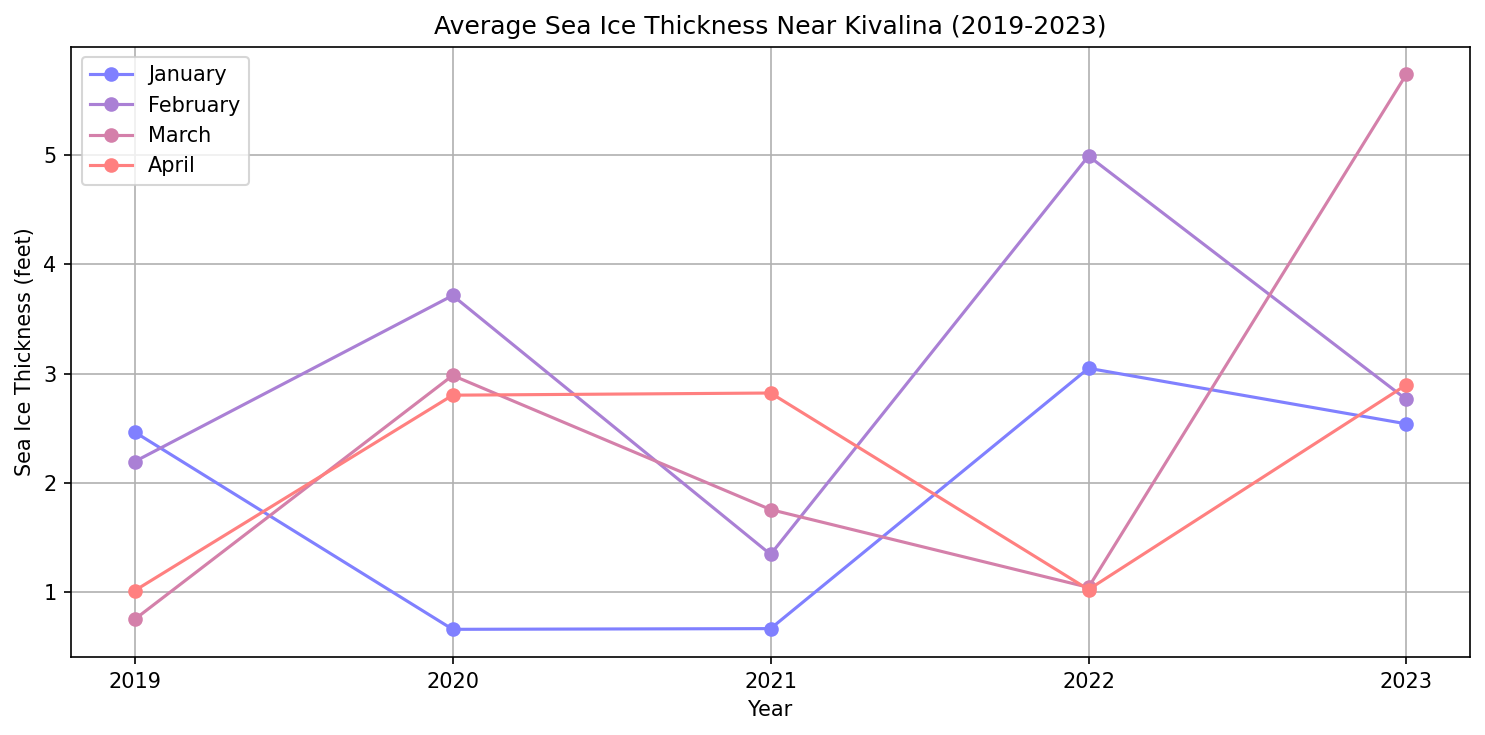

In [93]:
# adding all months to one scatterplot for a better look at the data 

thickness_values = {month: [] for month in range(1, 4)} 

for month in range(1, 5):
    for year in range(2019, 2024):
        month_data = IS2SITMOGR4_all.sel(time=IS2SITMOGR4_all['time'].dt.month == month)
        year_data = month_data.sel(time=month_data['time'].dt.year == year)

        if year_data.sizes['time'] > 0:
            values = year_data.isel(x=xr.DataArray(idx_closest_cells[1], dims="points"), 
                                    y=xr.DataArray(idx_closest_cells[0], dims="points")).ice_thickness_int.values
            
            average_thickness = np.nanmean(values) * METERS_TO_FEET
            thickness_values[month].append(average_thickness)
        else:
            thickness_values[month].append(np.nan)

colors = [(0.5, 0.5, 1), (1, 0.5, 0.5)]  
cmap_name = "custom_color_map"
custom_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=4)  # N=4 for 4 months

plt.figure(figsize=(10, 5))
labels = ['January', 'February', 'March', 'April']
years = range(2019, 2024)

for i, month in enumerate(range(1, 5)):
    plt.plot(years, thickness_values[month], marker='o', linestyle='-', color=custom_cmap(i / 3), label=labels[i])

plt.title('Average Sea Ice Thickness Near Kivalina (2019-2023)')
plt.xlabel('Year')
plt.ylabel('Sea Ice Thickness (feet)')
plt.grid(True)
plt.xticks(list(years))
plt.legend()
plt.tight_layout()
plt.show()





# Visually Assessing Sea Ice Thickness Change 
## A closer look at sea ice thickness gridcells near Kivalina
### Next, I will repeat this analysis and "zoom out", visually assessing sea ice thickness gridcells and their changes near Kivalina, AK. 

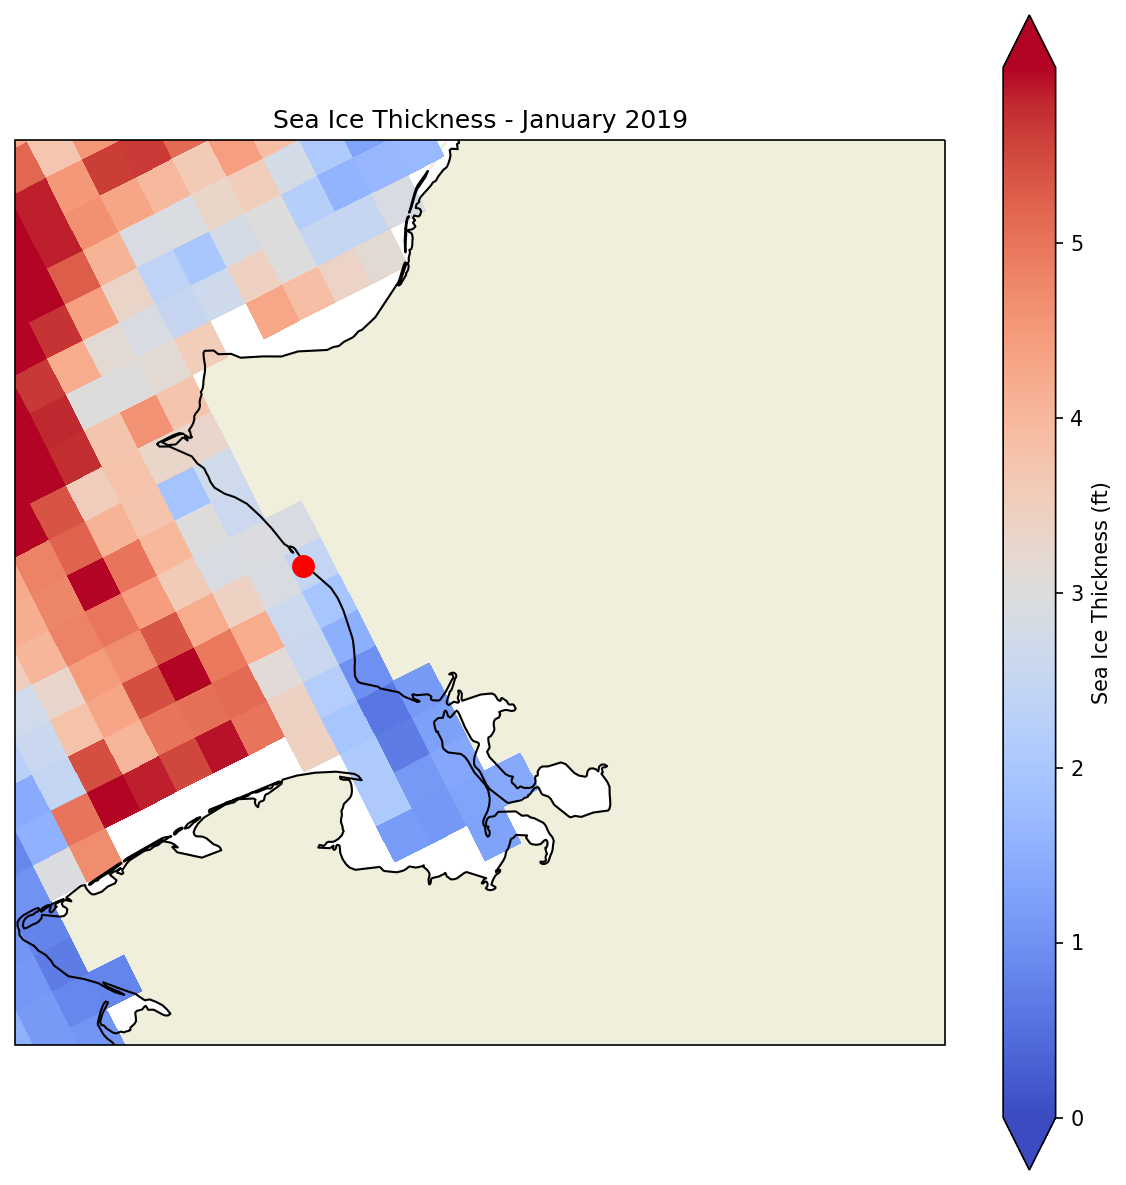

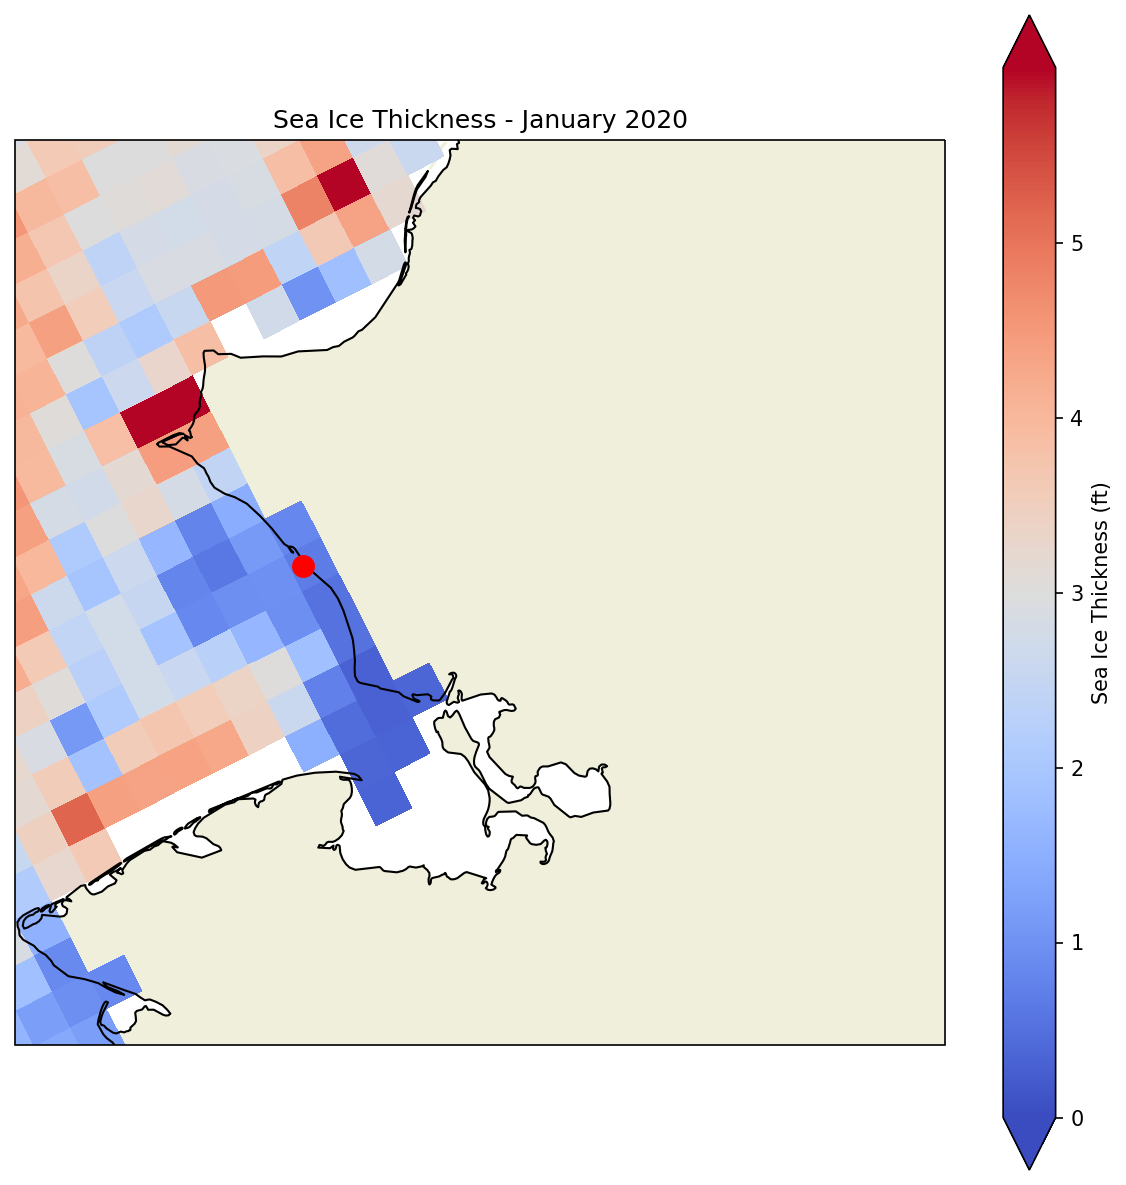

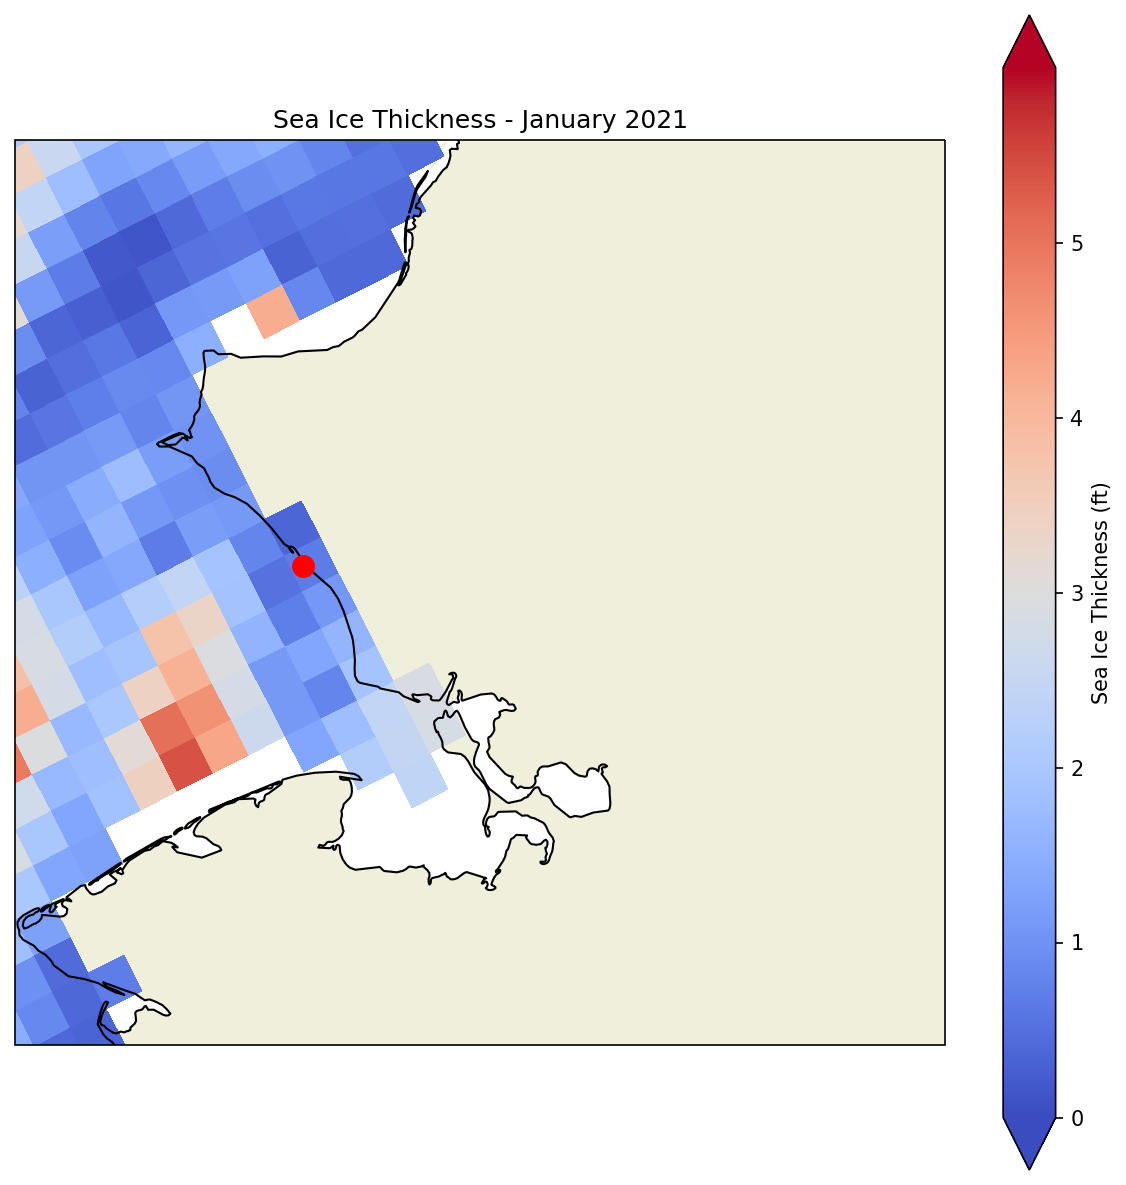

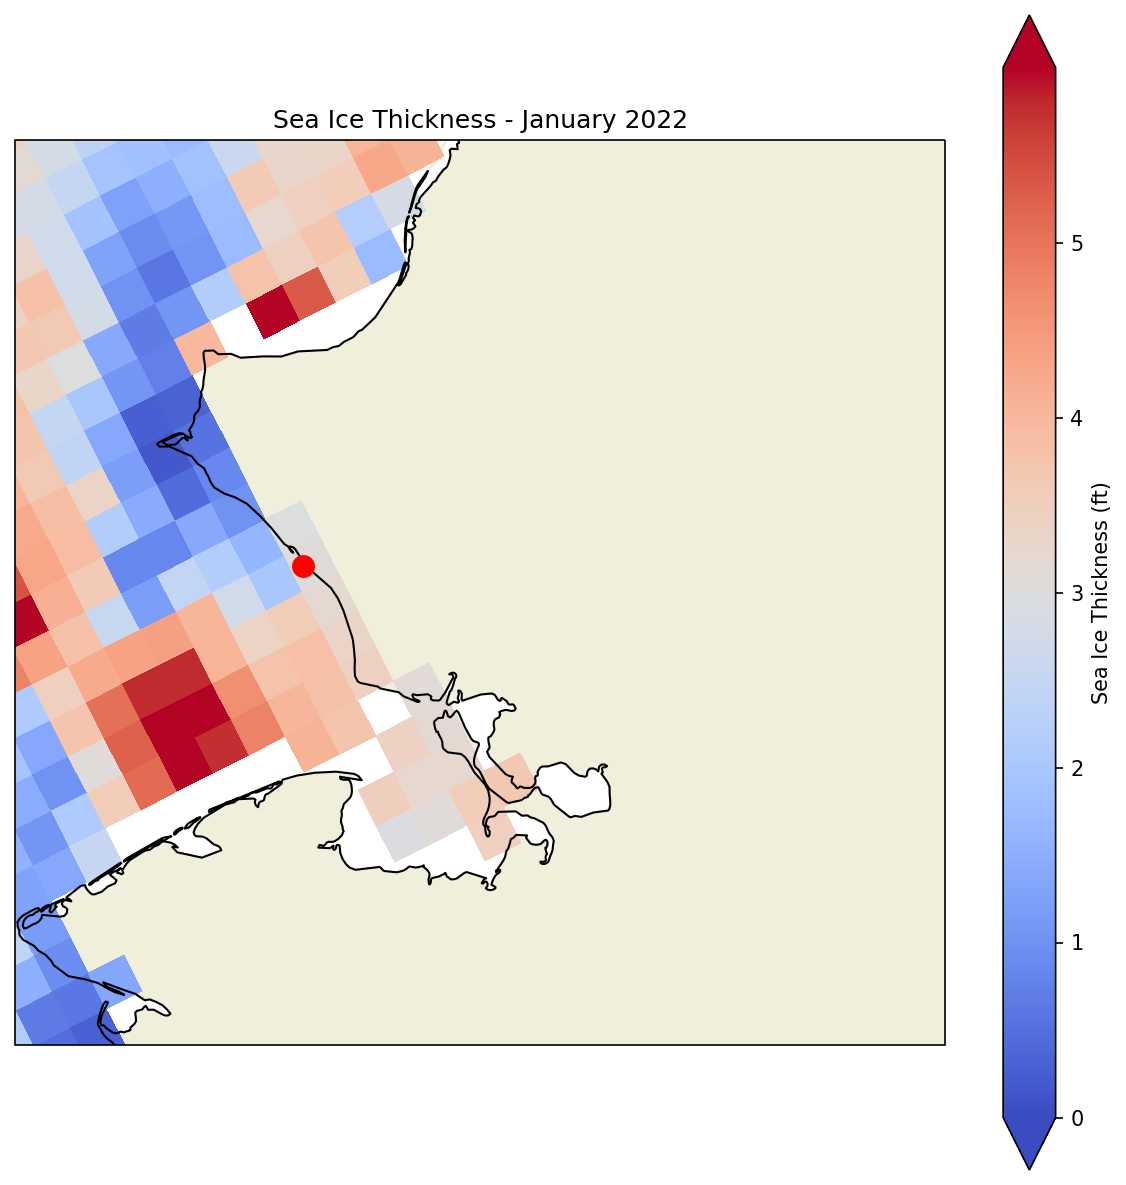

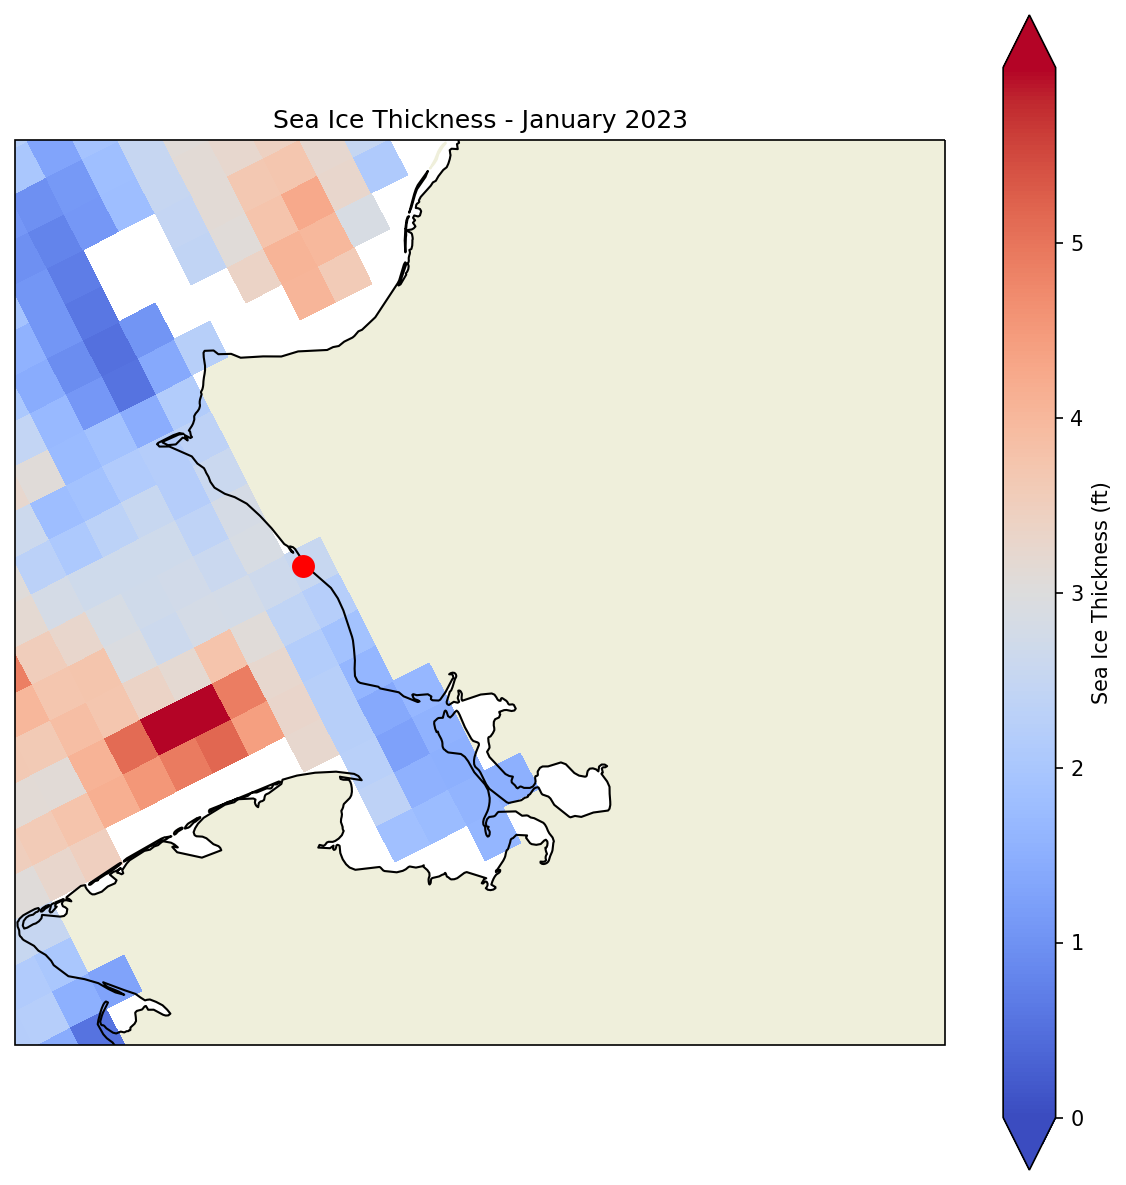

In [95]:
##January Static Sea Ice Thickness Maps
def compute_gridcell_monthly_data(data, month, year):
    monthly_data = data.sel(time=(data['time'].dt.year == year) & (data['time'].dt.month == month))
    
    # Drop non-unique times (this step might remove some data, so use cautiously)
    _, index = np.unique(monthly_data['time'], return_index=True)
    monthly_data = monthly_data.isel(time=index)
    
    return monthly_data

region_extent = [-168, -156, 65, 70]  # [west, east, south, north]
projection = ccrs.NorthPolarStereo(central_longitude=(region_extent[0] + region_extent[1]) / 2)

kivalina_longitude = -164.5636  # Replace with the actual longitude of Kivalina
kivalina_latitude = 67.7316  # Replace with the actual latitude of Kivalina

years = [2018, 2019, 2020, 2021, 2022, 2023]
for year in years:
    monthly_data = compute_gridcell_monthly_data(IS2SITMOGR4_all.ice_thickness_int, 1, year)
    # proceed only if there's data 
    if monthly_data.sizes['time'] > 0:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        sea_ice_thickness_in_feet = monthly_data.values.squeeze() * METERS_TO_FEET  

        sea_ice_plot = ax.pcolormesh(
            monthly_data['longitude'], 
            monthly_data['latitude'], 
            sea_ice_thickness_in_feet,
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            vmin=0,  
            vmax=6  
        )

        cbar = plt.colorbar(sea_ice_plot, ax=ax, orientation='vertical', extend='both')
        cbar.set_label('Sea Ice Thickness (ft)')
        cbar.set_ticks([0, 1, 2, 3, 4, 5])  # Optional: Set specific tick marks
        cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])  # Optional: Format tick labels
        
        ax.plot(kivalina_longitude, kivalina_latitude, marker='o', markersize=10, color='red', transform=ccrs.PlateCarree())
        
        plt.title(f'Sea Ice Thickness - January {year}')
        plt.show()


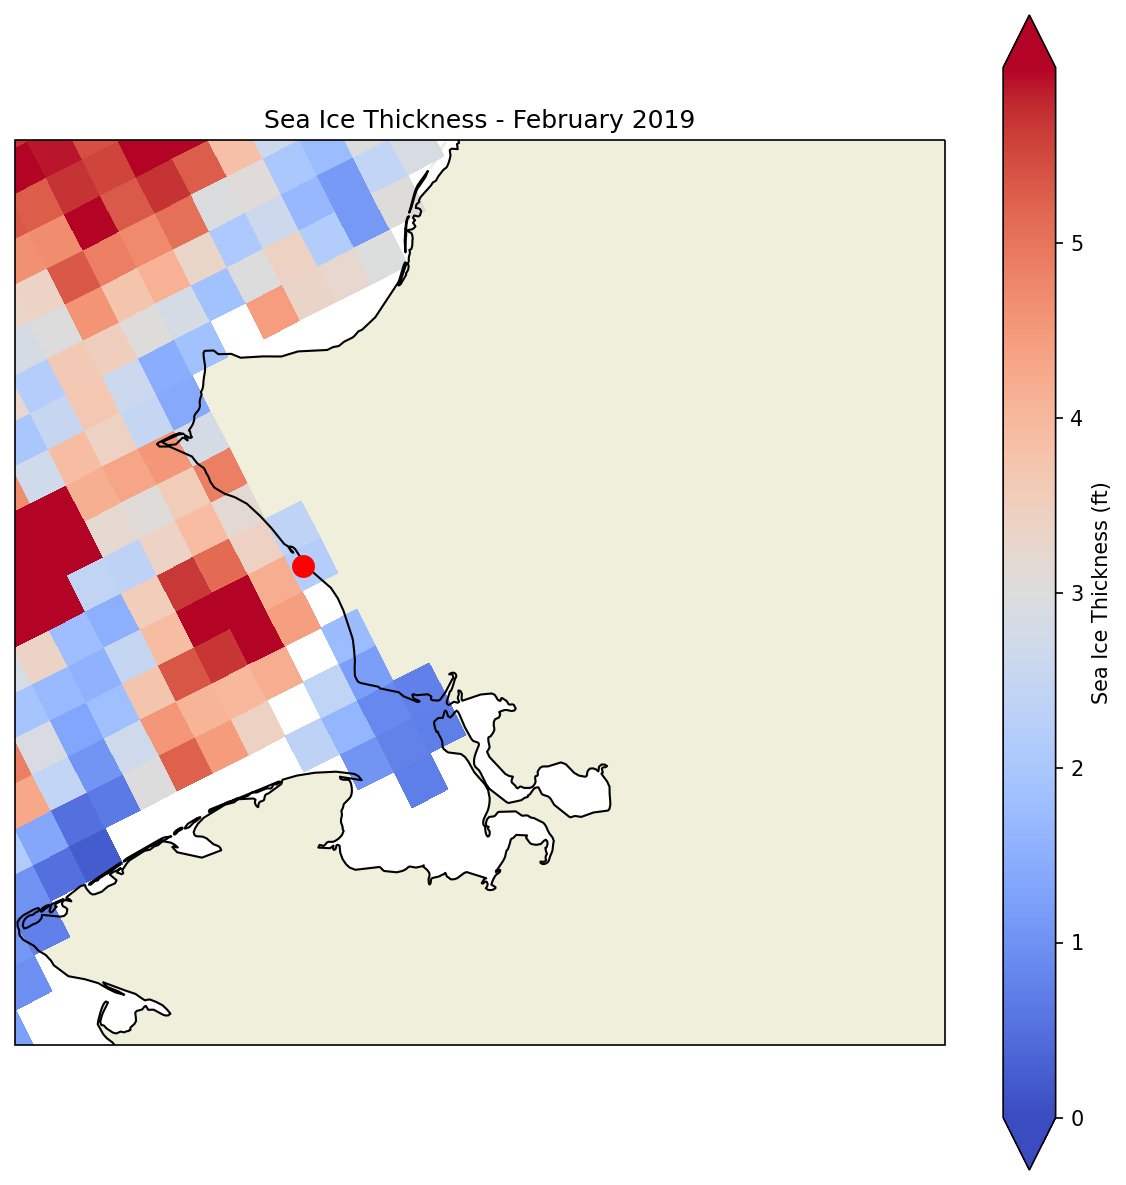

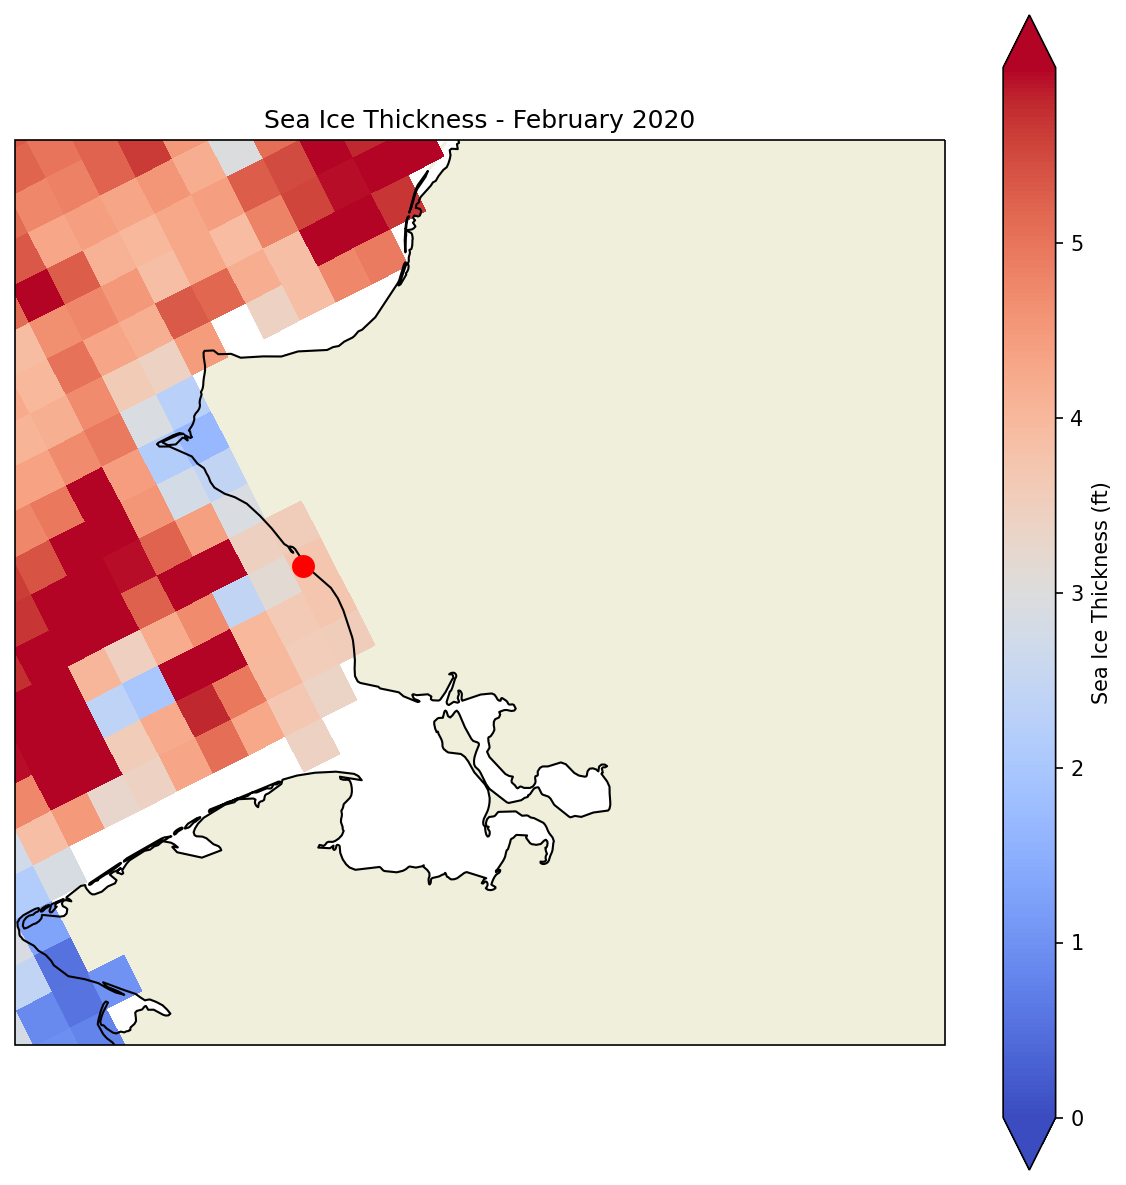

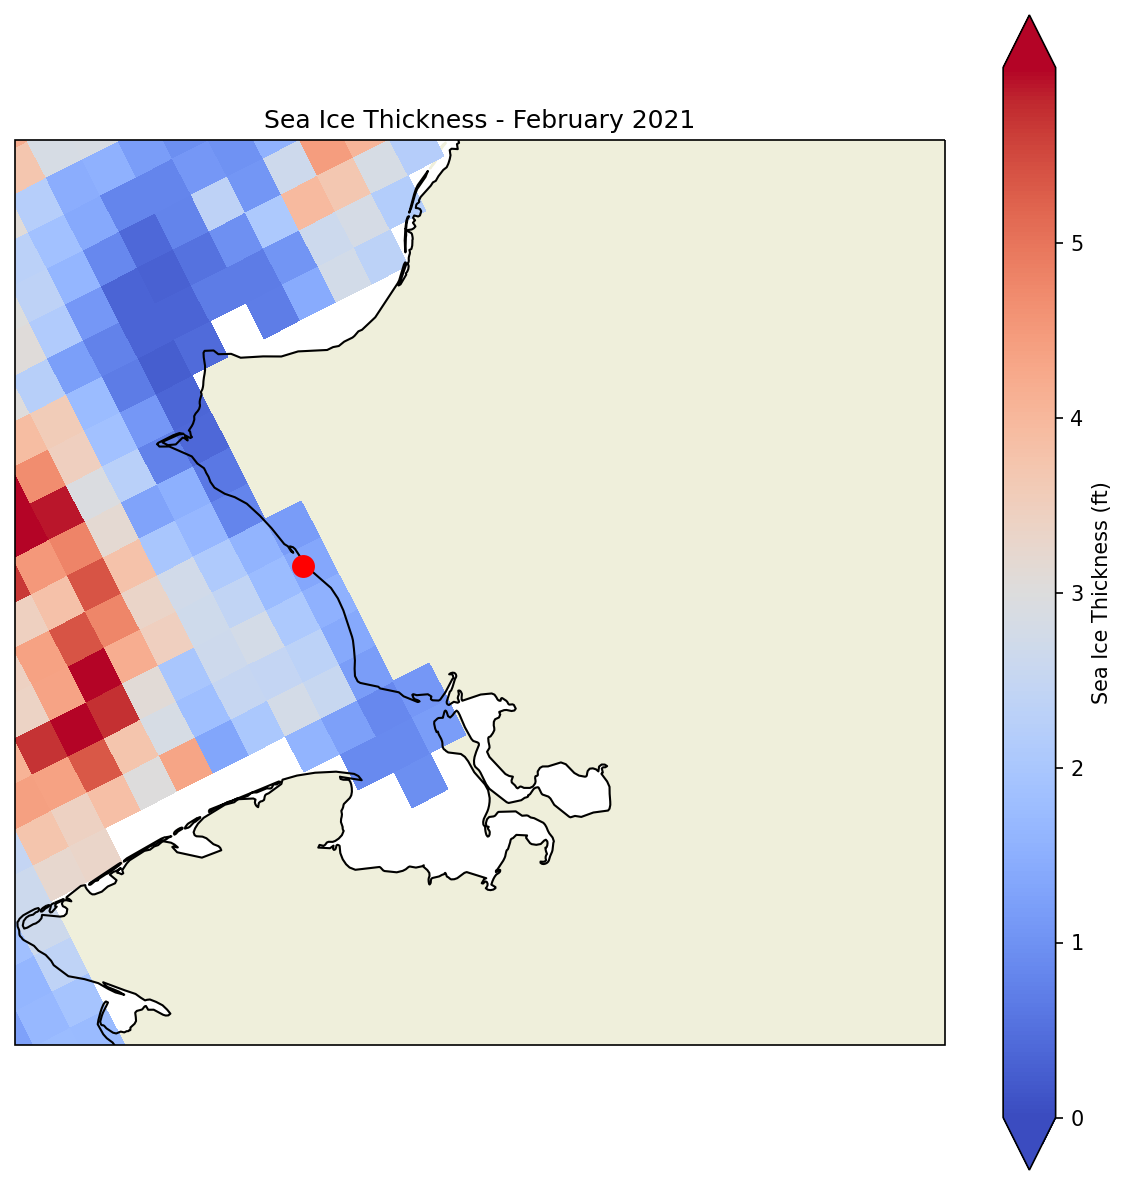

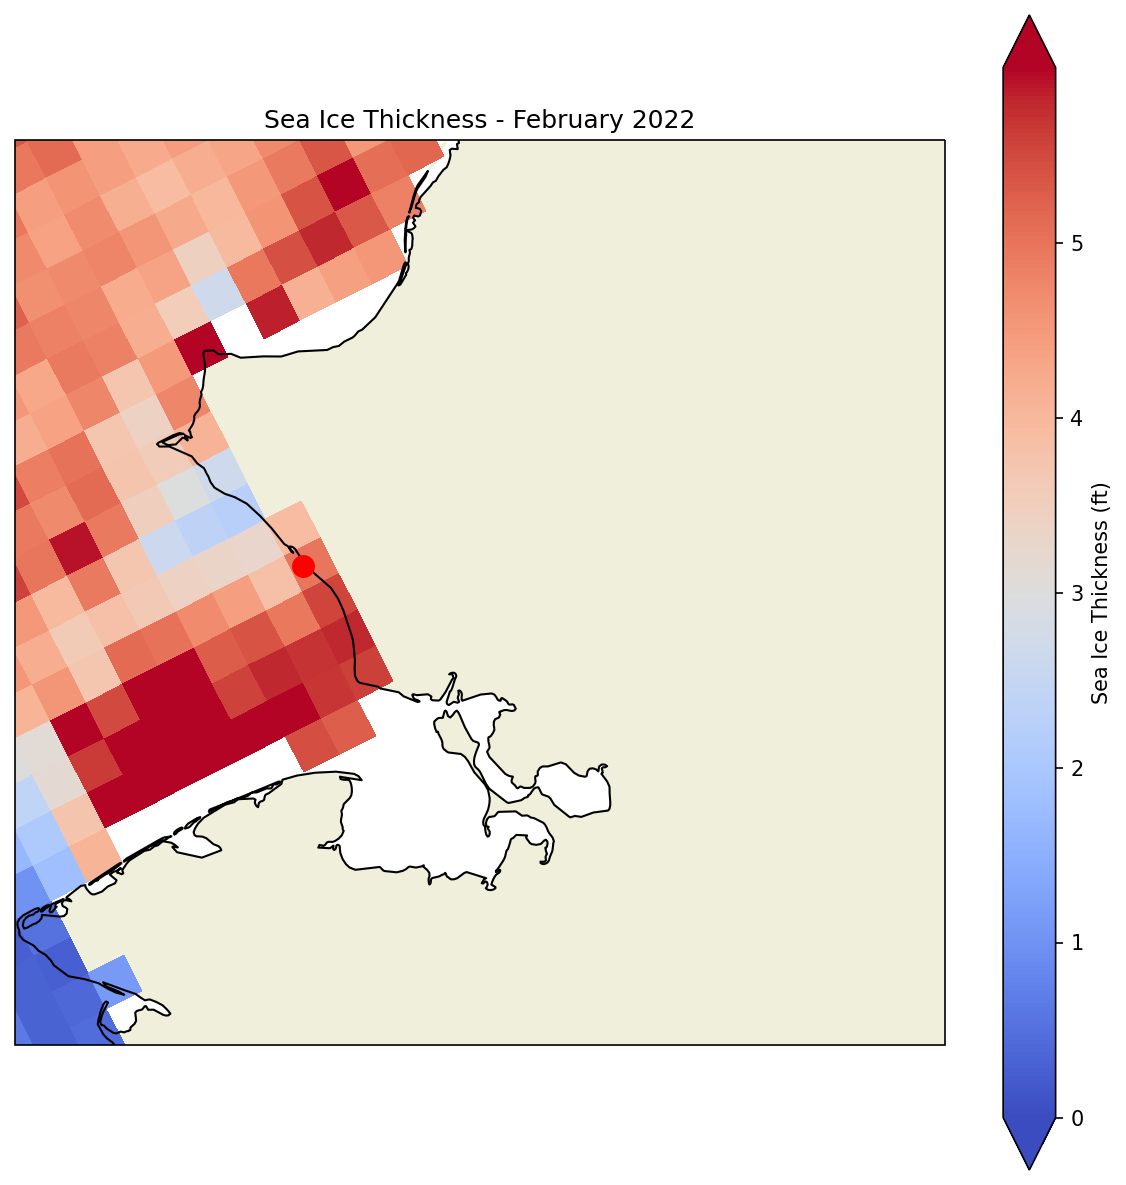

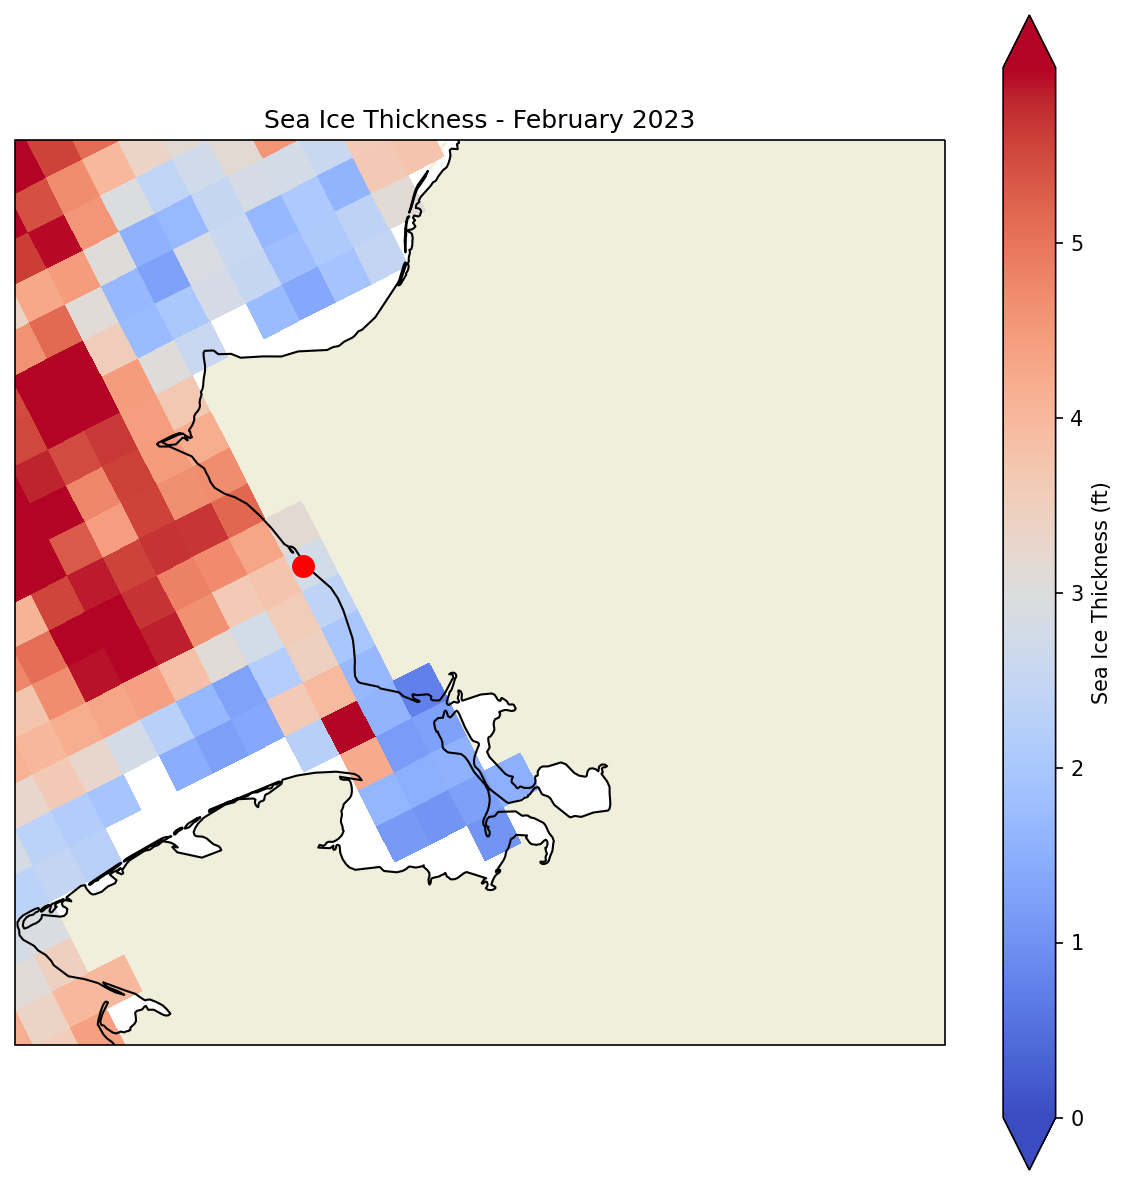

In [98]:
#static february sea ice thickness maps 

def compute_gridcell_monthly_data(data, month, year):
    monthly_data = data.sel(time=(data['time'].dt.year == year) & (data['time'].dt.month == month))
    _, index = np.unique(monthly_data['time'], return_index=True)
    monthly_data = monthly_data.isel(time=index)
    
    return monthly_data

region_extent = [-168, -156, 65, 70]  # [west, east, south, north]
projection = ccrs.NorthPolarStereo(central_longitude=(region_extent[0] + region_extent[1]) / 2)

years = [2018, 2019, 2020, 2021, 2022, 2023]
for year in years:
    monthly_data = compute_gridcell_monthly_data(IS2SITMOGR4_all.ice_thickness_int, 2, year)
    if monthly_data.sizes['time'] > 0:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        sea_ice_thickness_in_feet = monthly_data.values.squeeze() * METERS_TO_FEET  # Adjust as necessary for your data's dimensions
        sea_ice_plot = ax.pcolormesh(
            monthly_data['longitude'], 
            monthly_data['latitude'], 
            sea_ice_thickness_in_feet,
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            vmin=0,  
            vmax=6  
        )

    # symbol for Kivalina
        ax.plot(kivalina_longitude, kivalina_latitude, marker='o', markersize=10, color='red', transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sea_ice_plot, ax=ax, orientation='vertical', extend='both')
        cbar.set_label('Sea Ice Thickness (ft)')
        cbar.set_ticks([0, 1, 2, 3, 4, 5])  
        cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '5'])  
        plt.title(f'Sea Ice Thickness - February {year}')
        plt.show()


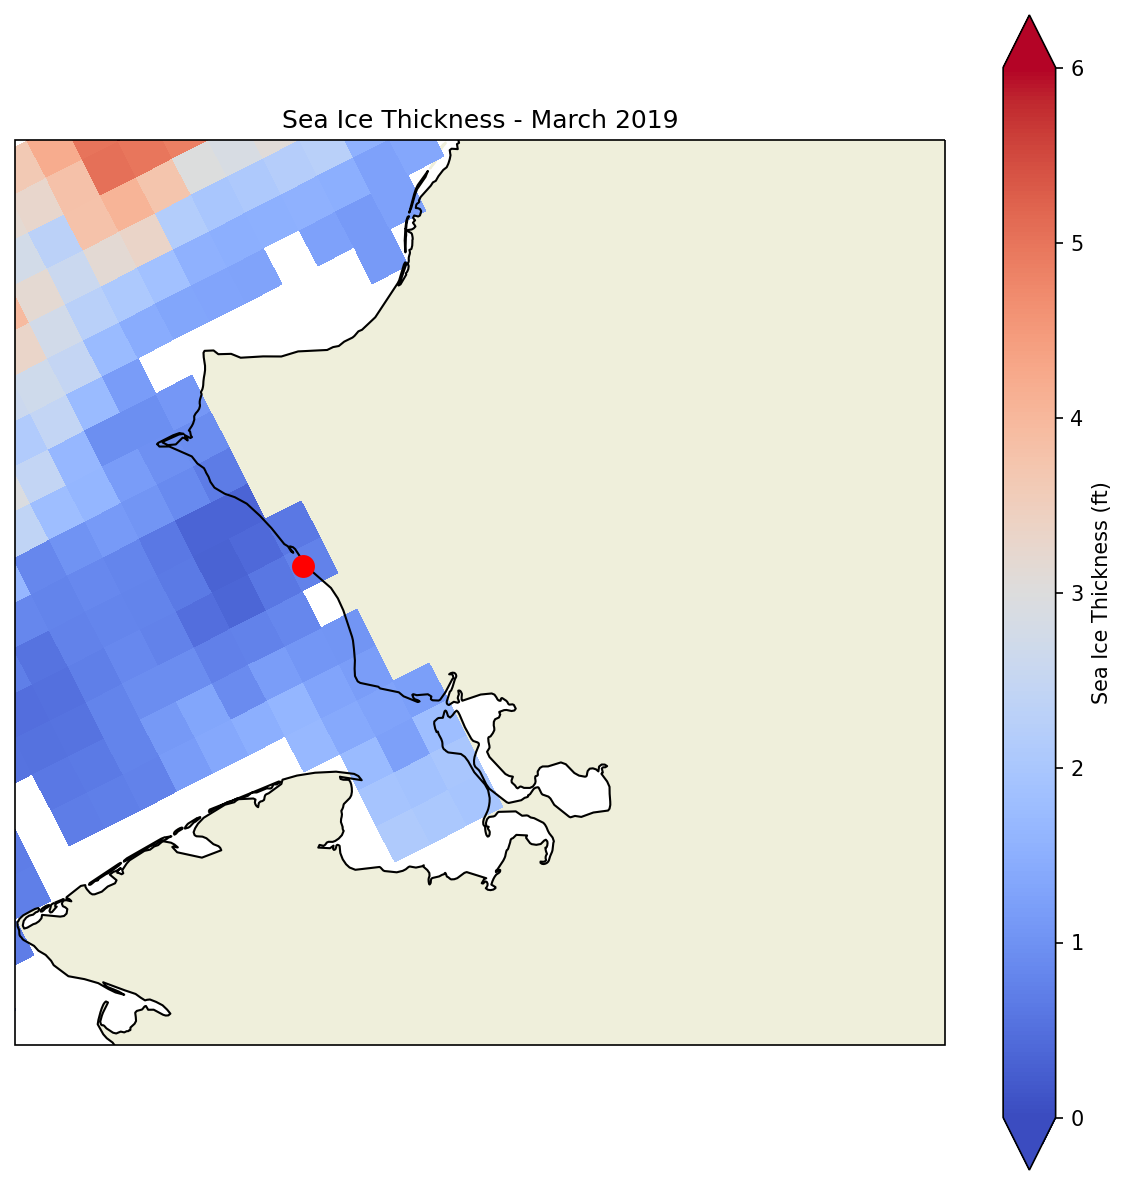

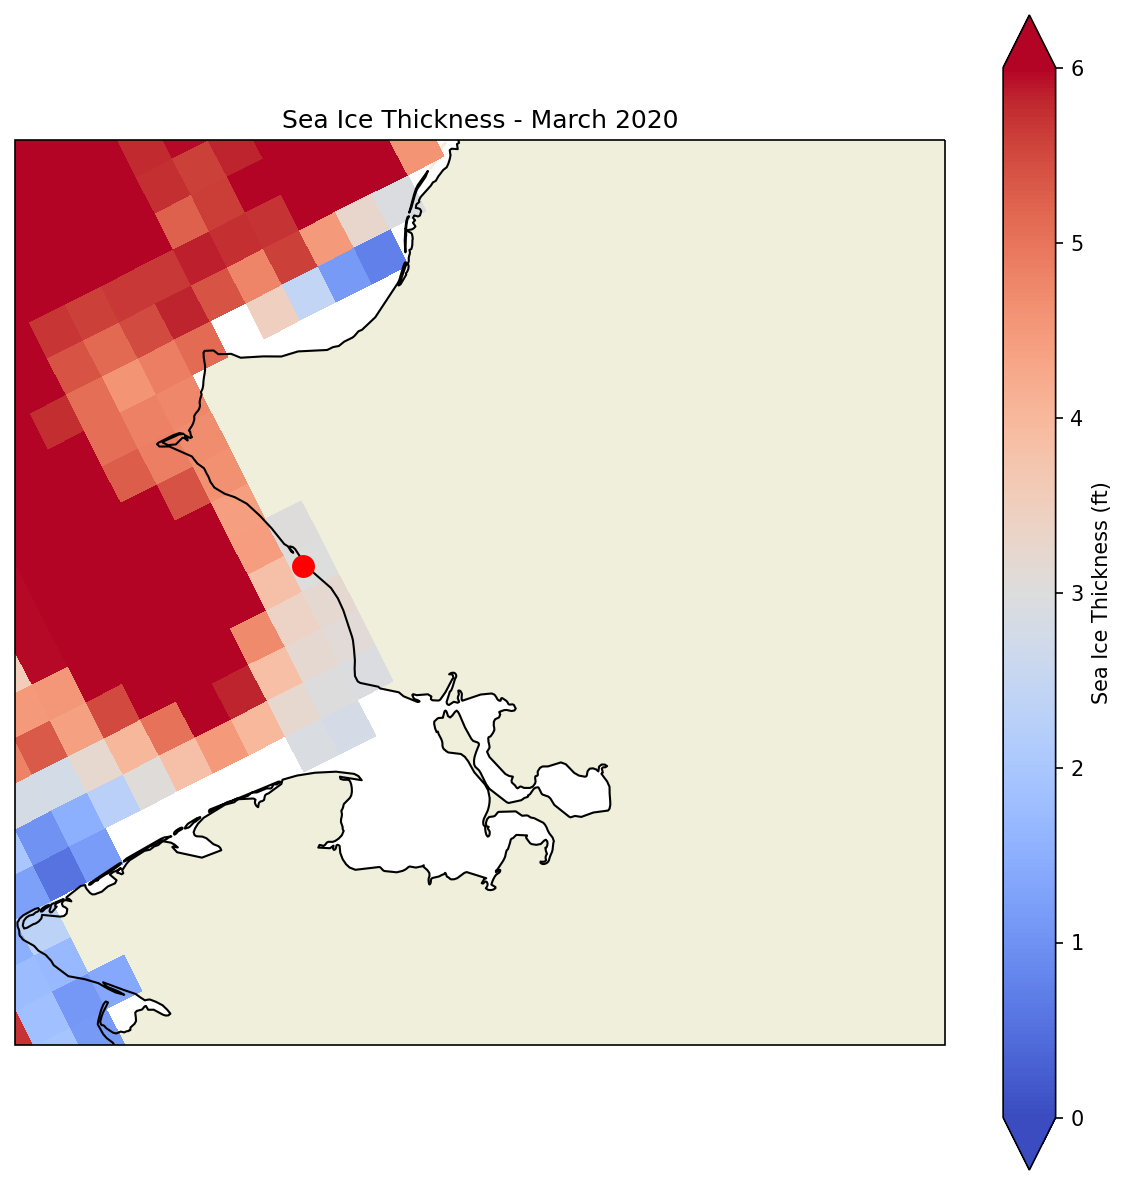

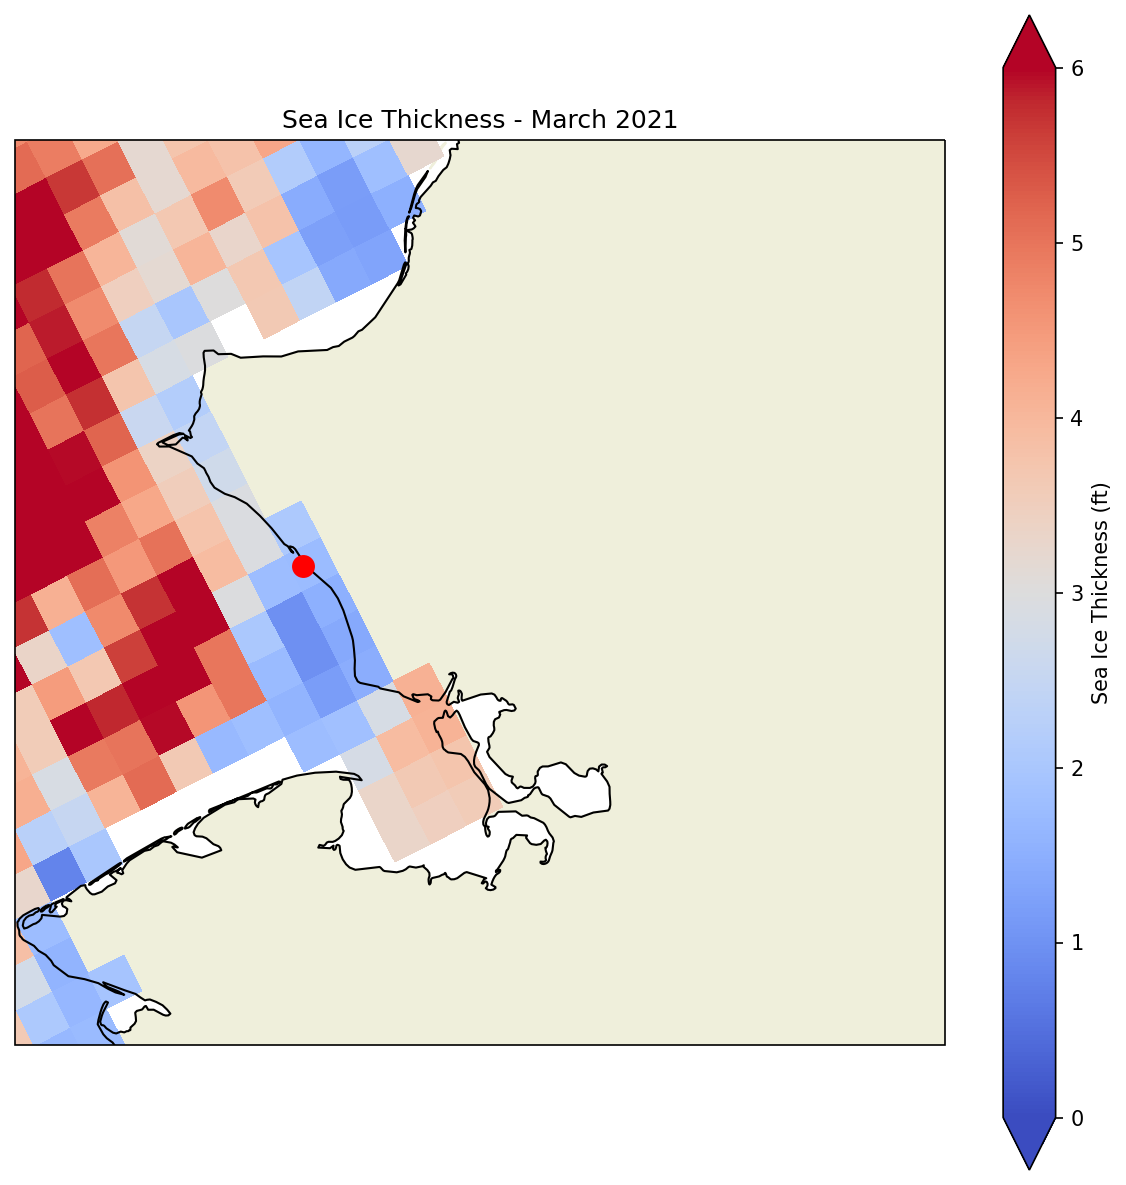

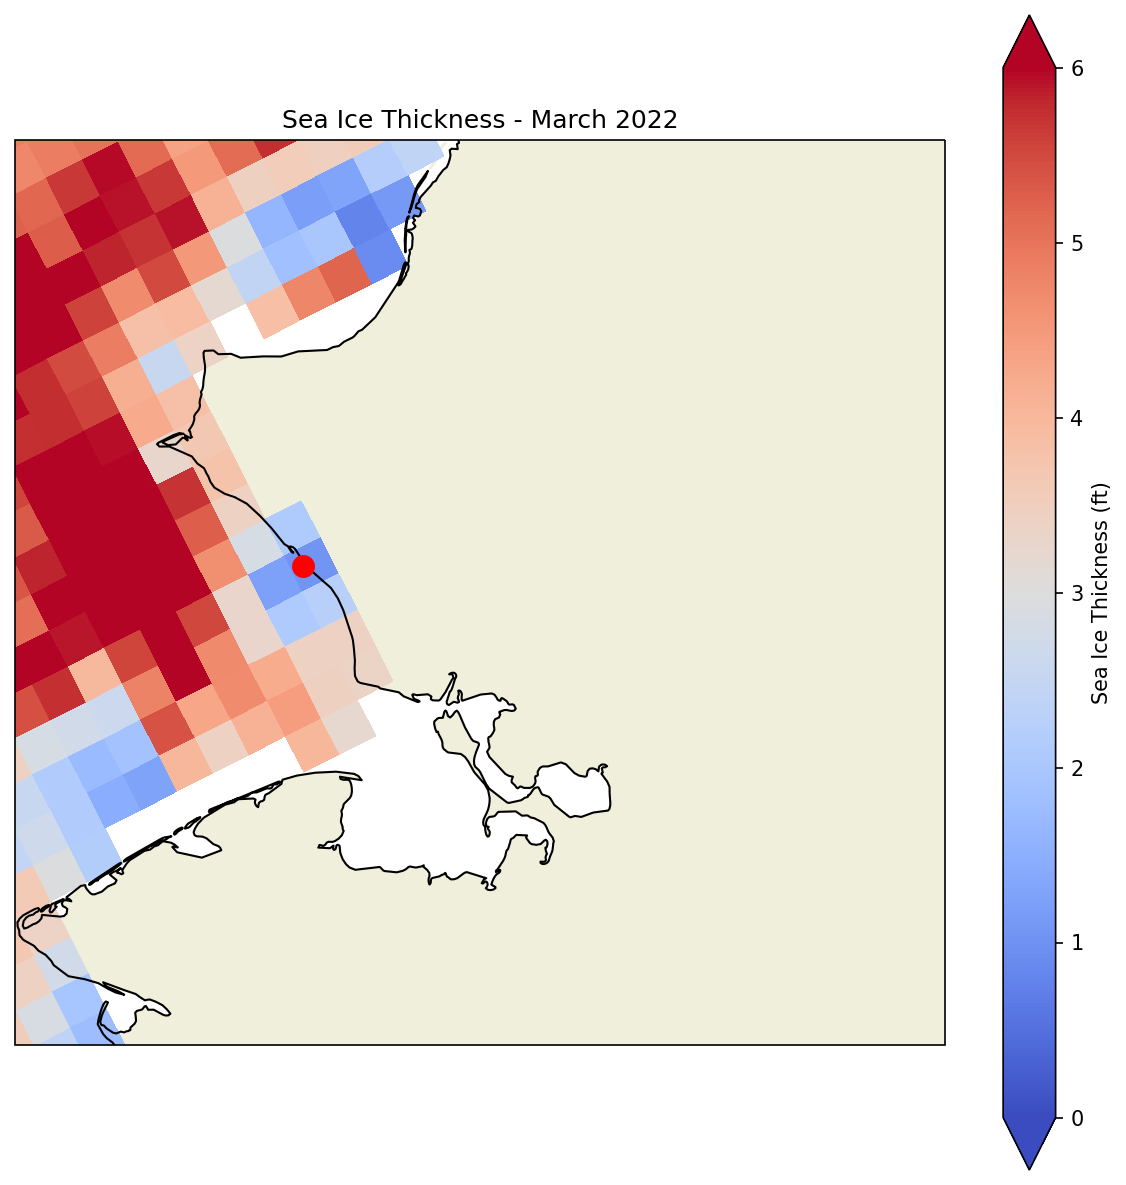

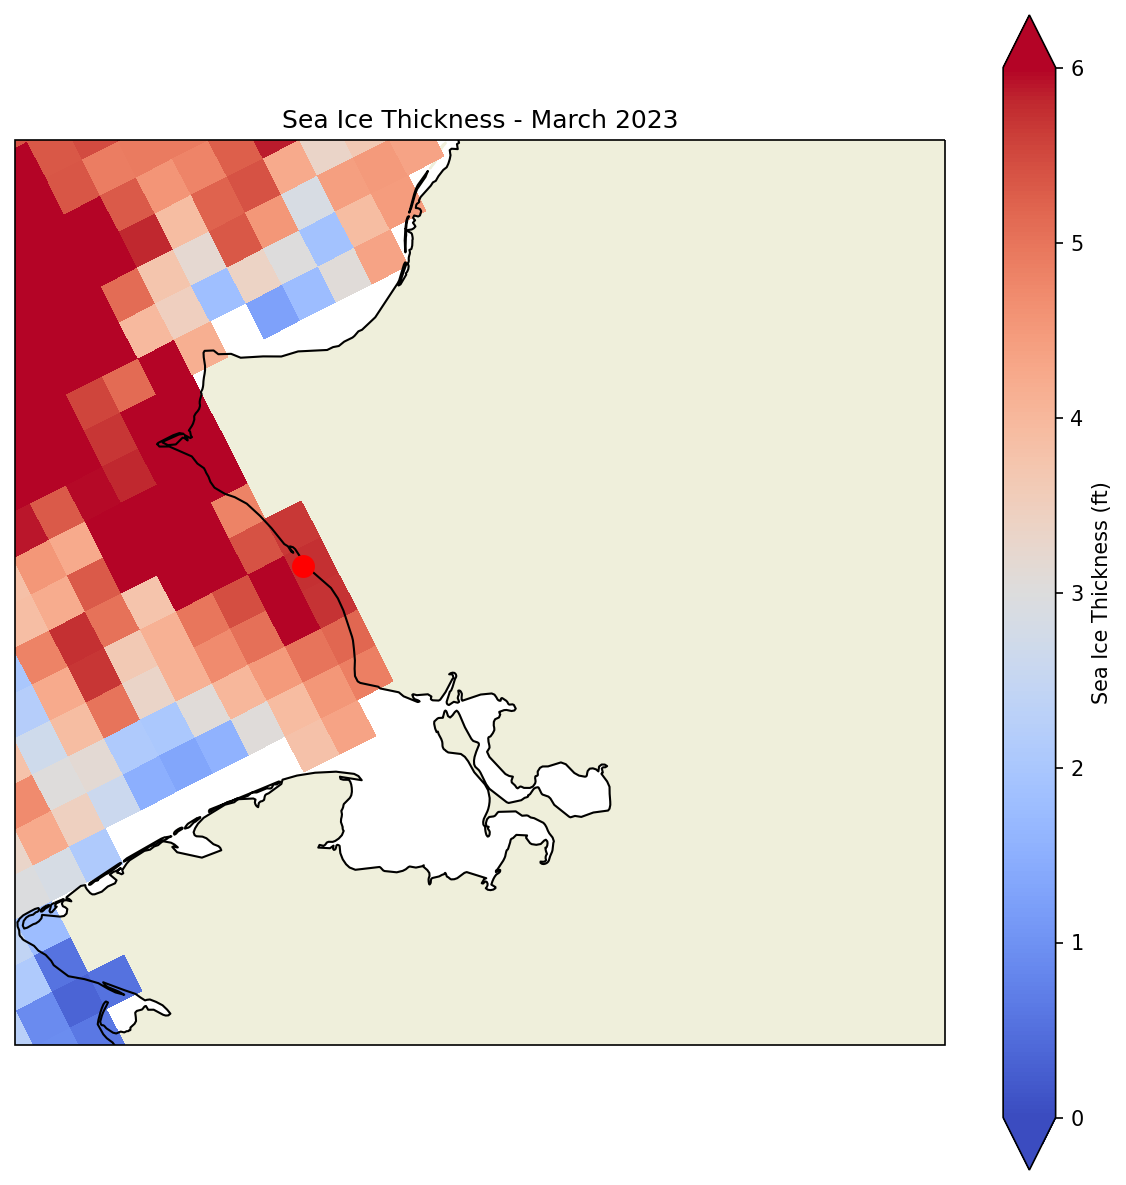

In [99]:
#march sea ice thickness 
def compute_gridcell_monthly_data(data, month, year):
    monthly_data = data.sel(time=(data['time'].dt.year == year) & (data['time'].dt.month == month))
    _, index = np.unique(monthly_data['time'], return_index=True)
    monthly_data = monthly_data.isel(time=index)
    return monthly_data

region_extent = [-168, -156, 65, 70]
projection = ccrs.NorthPolarStereo(central_longitude=(region_extent[0] + region_extent[1]) / 2)

years = [2018, 2019, 2020, 2021, 2022, 2023]
for year in years:
    monthly_data = compute_gridcell_monthly_data(IS2SITMOGR4_all.ice_thickness_int, 3, year)

    if monthly_data.sizes['time'] > 0:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        sea_ice_thickness_in_feet = monthly_data.values.squeeze() * METERS_TO_FEET

        sea_ice_plot = ax.pcolormesh(
            monthly_data['longitude'], 
            monthly_data['latitude'], 
            sea_ice_thickness_in_feet,
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            vmin=0, 
            vmax=6
        )

# symbol for Kivalina
        ax.plot(kivalina_longitude, kivalina_latitude, marker='o', markersize=10, color='red', transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sea_ice_plot, ax=ax, orientation='vertical', extend='both')
        cbar.set_label('Sea Ice Thickness (ft)')
        plt.title(f'Sea Ice Thickness - March {year}')
        plt.show()


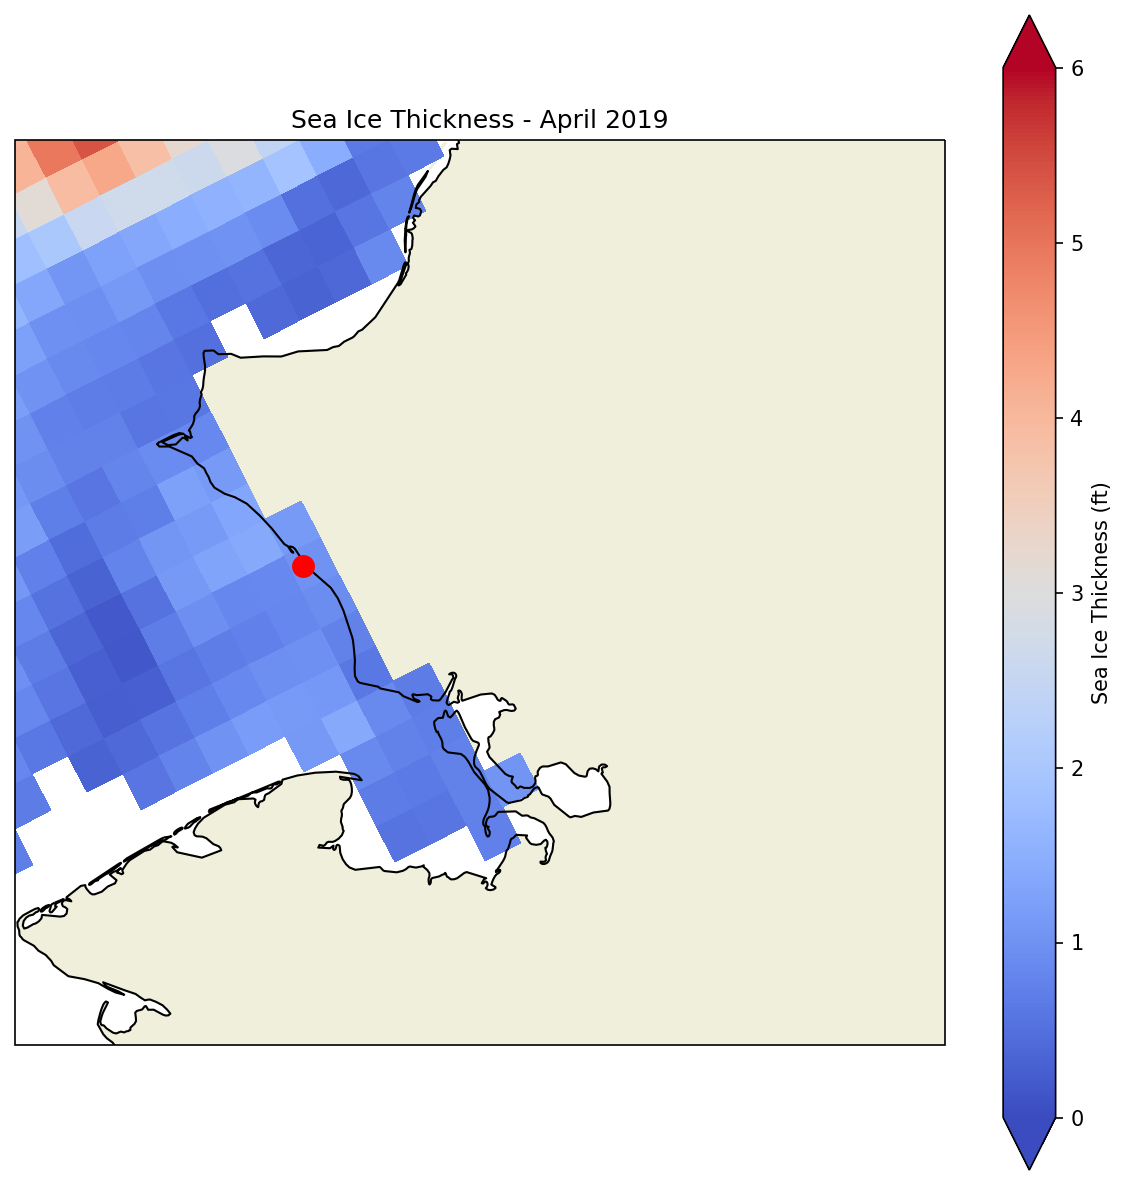

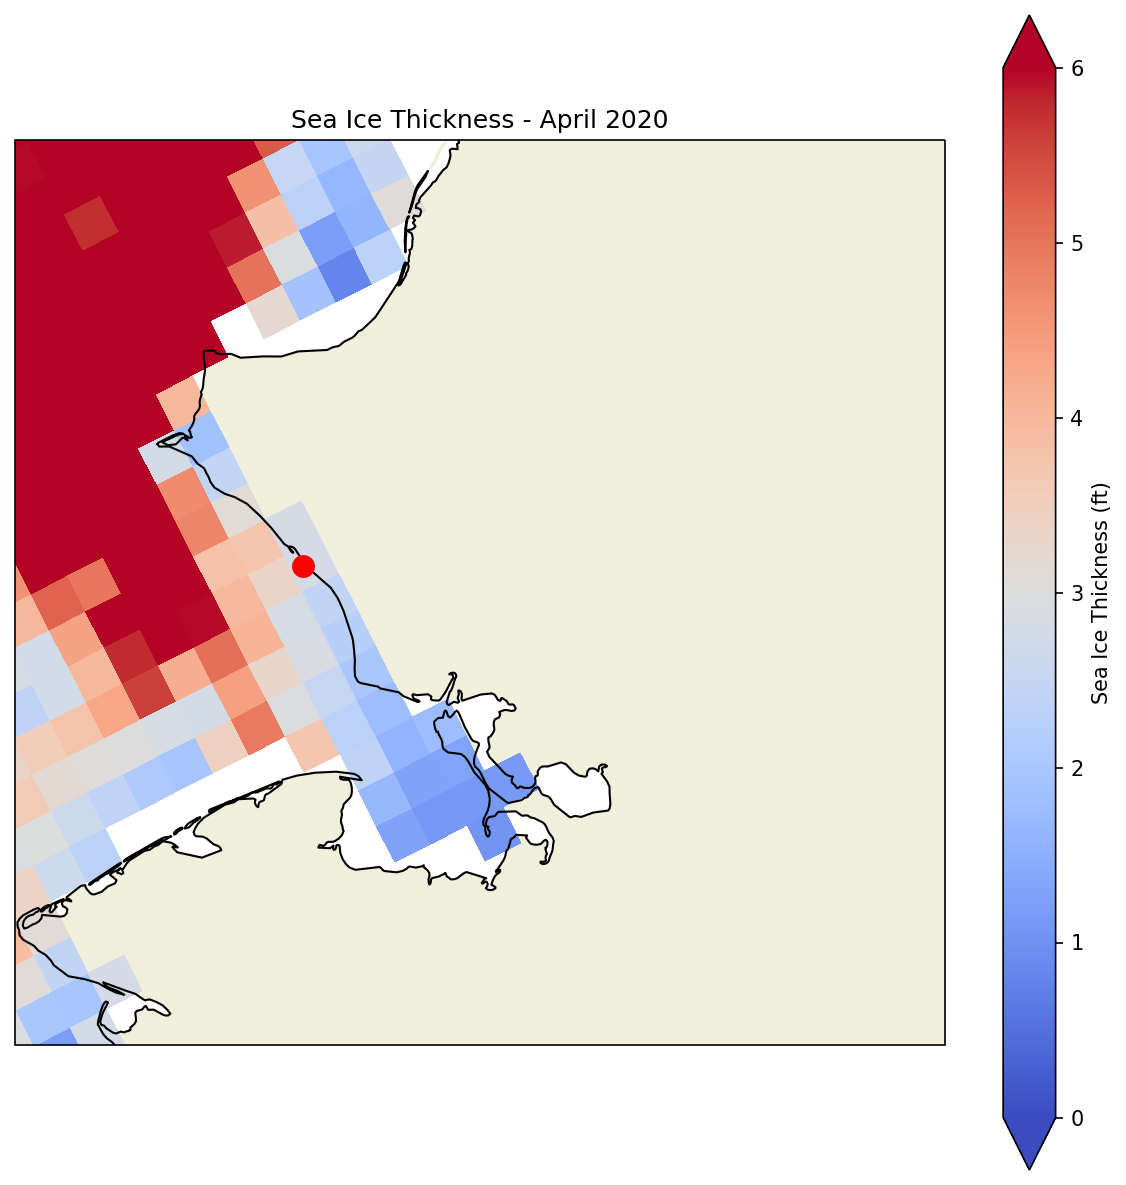

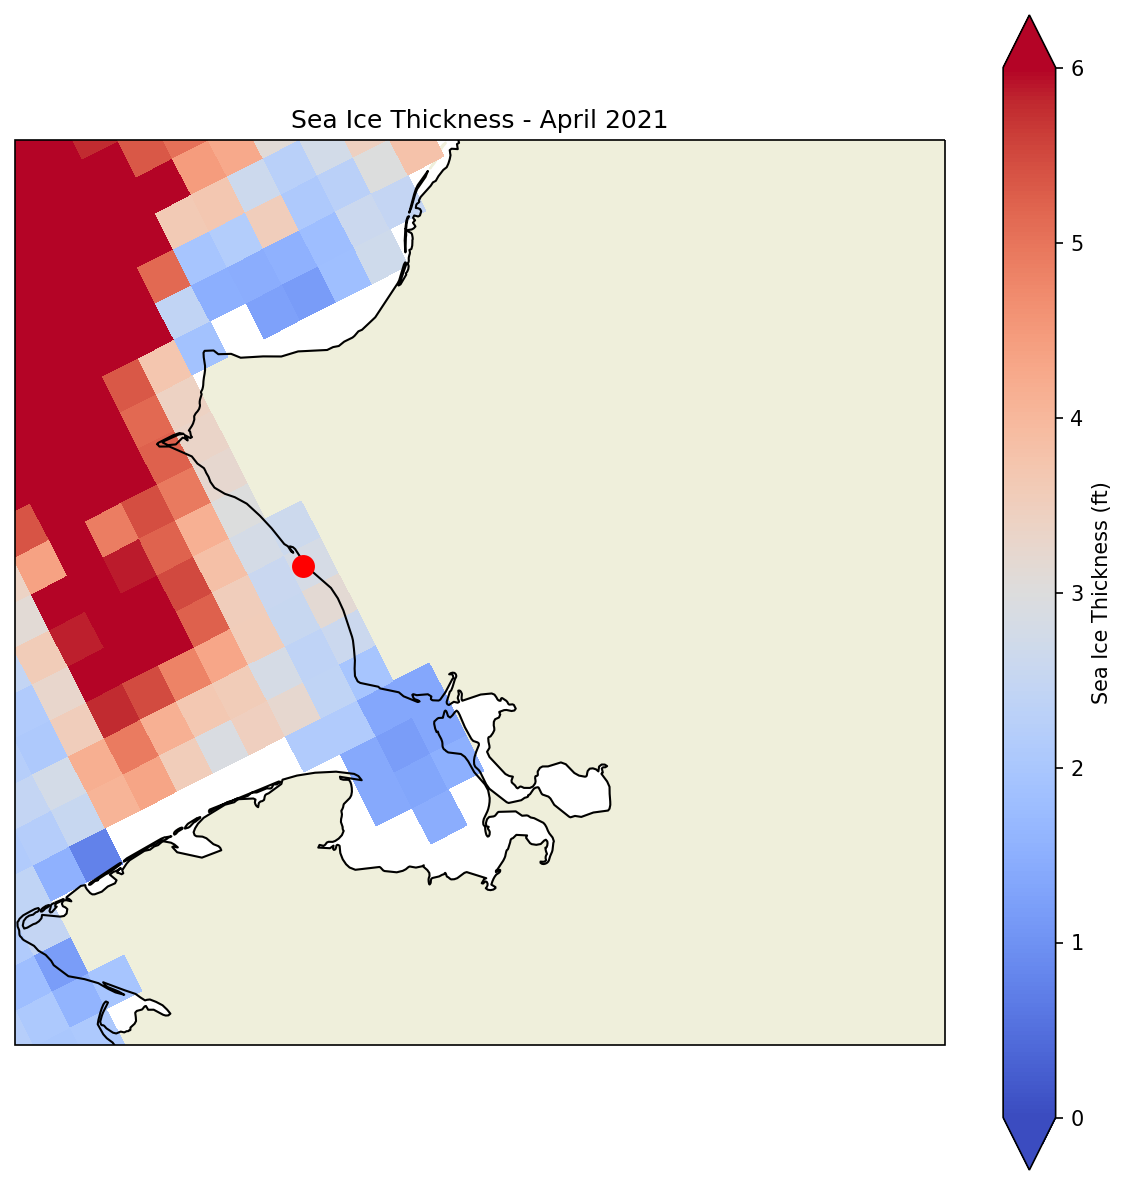

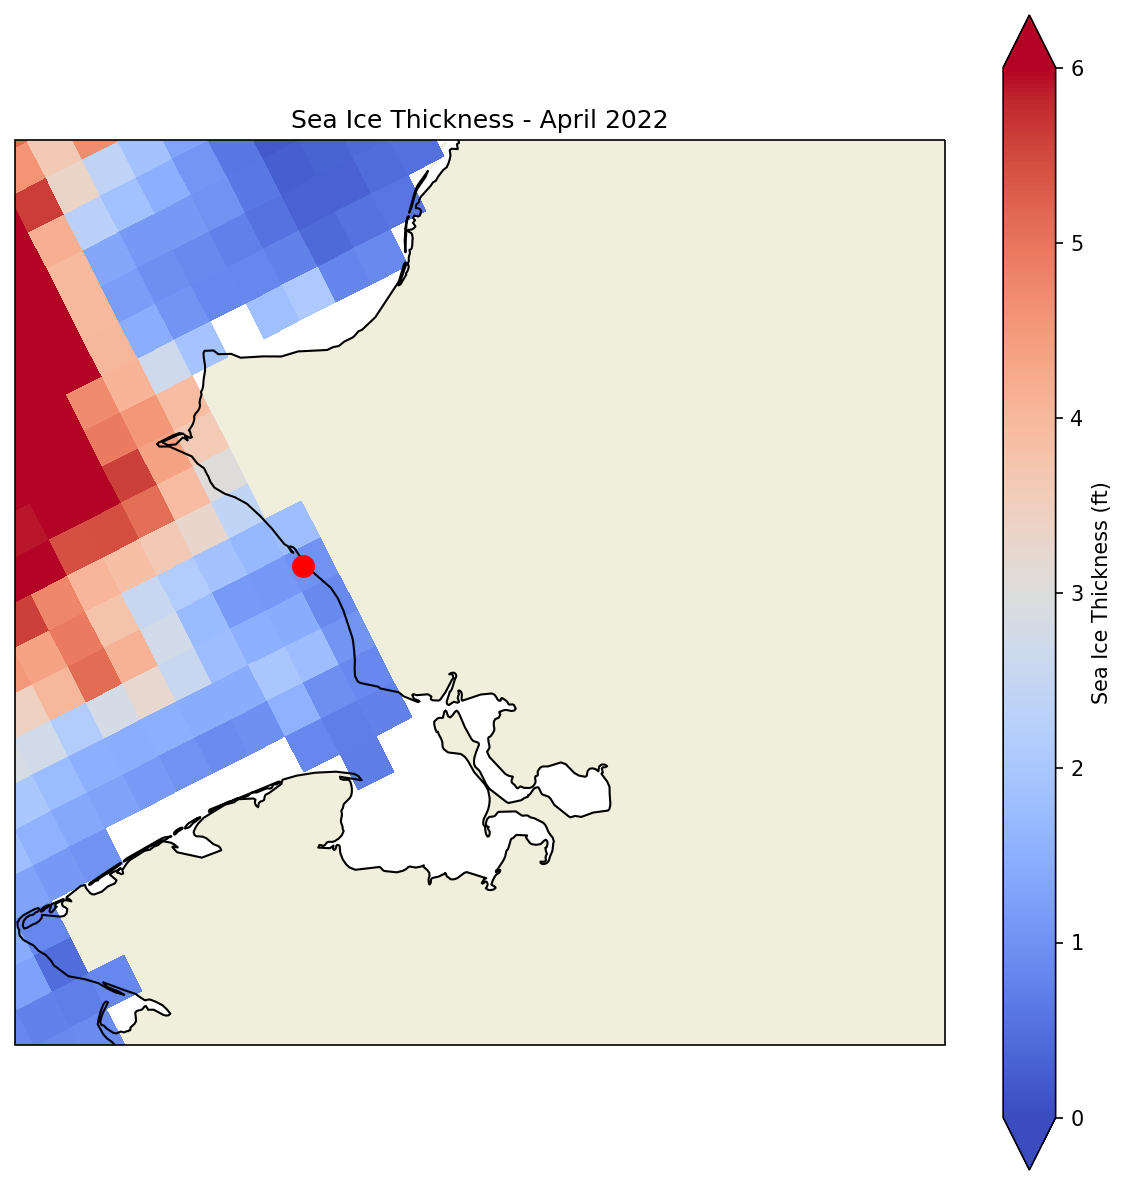

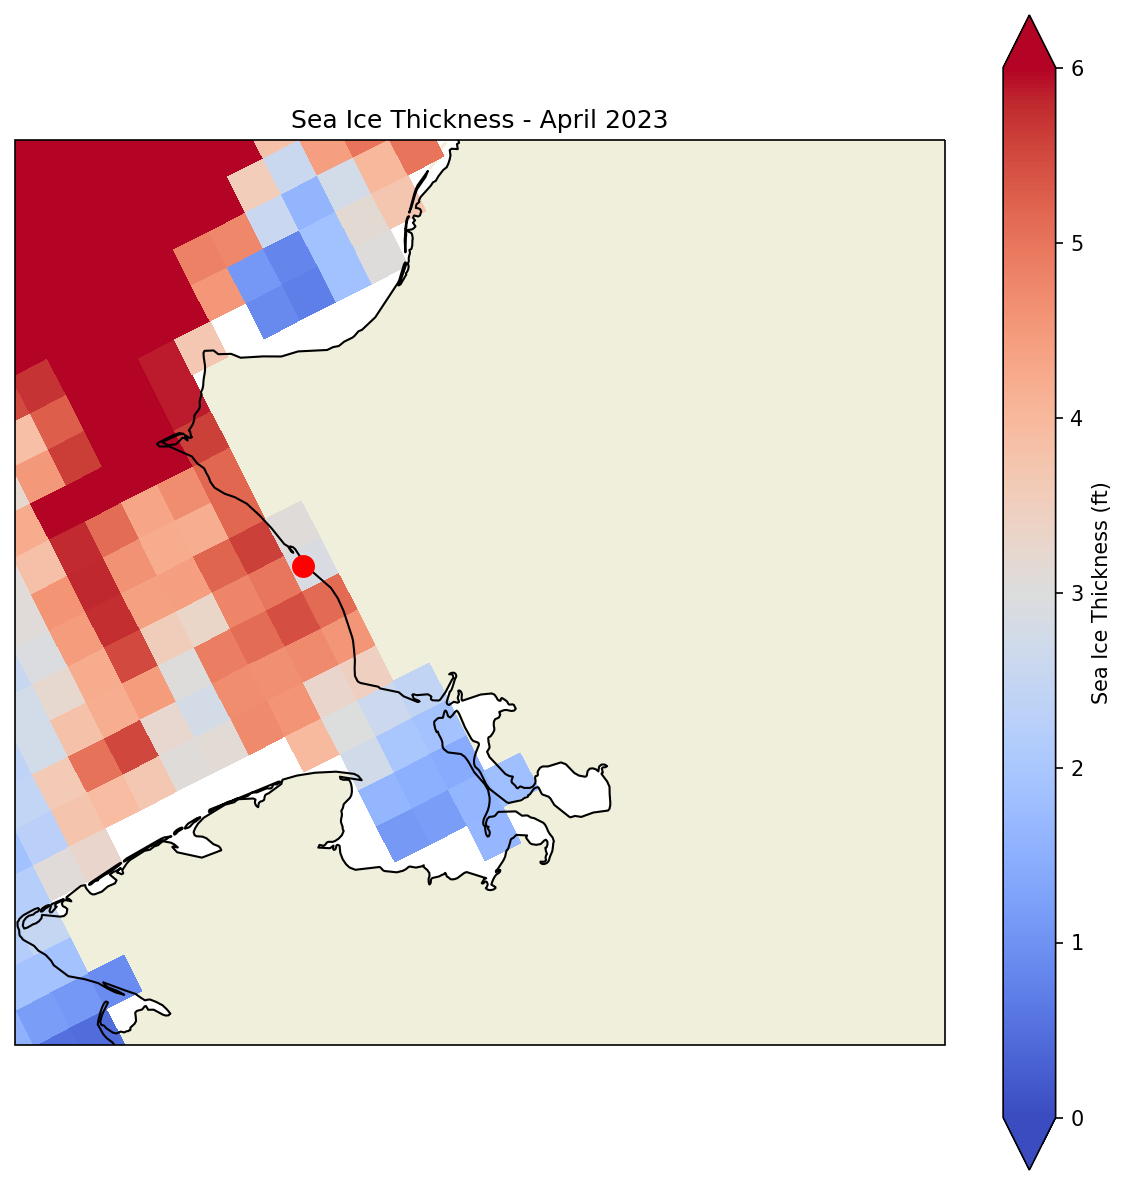

In [100]:
#april static sea ice thickness map 
def compute_gridcell_monthly_data(data, month, year):
    monthly_data = data.sel(time=(data['time'].dt.year == year) & (data['time'].dt.month == month))
    _, index = np.unique(monthly_data['time'], return_index=True)
    monthly_data = monthly_data.isel(time=index)
    return monthly_data

region_extent = [-168, -156, 65, 70]
projection = ccrs.NorthPolarStereo(central_longitude=(region_extent[0] + region_extent[1]) / 2)

years = [2018, 2019, 2020, 2021, 2022, 2023]
for year in years:
    monthly_data = compute_gridcell_monthly_data(IS2SITMOGR4_all.ice_thickness_int, 4, year)
    if monthly_data.sizes['time'] > 0:
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': projection})
        ax.set_extent(region_extent, crs=ccrs.PlateCarree())
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        sea_ice_thickness_in_feet = monthly_data.values.squeeze() * METERS_TO_FEET

        sea_ice_plot = ax.pcolormesh(
            monthly_data['longitude'], 
            monthly_data['latitude'], 
            sea_ice_thickness_in_feet,
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',
            vmin=0, 
            vmax=6
        )

# symbol for Kivalina
        ax.plot(kivalina_longitude, kivalina_latitude, marker='o', markersize=10, color='red', transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sea_ice_plot, ax=ax, orientation='vertical', extend='both')
        cbar.set_label('Sea Ice Thickness (ft)')
        plt.title(f'Sea Ice Thickness - April {year}')
        plt.show()





In [23]:
## January Interactive
import holoviews as hv
from holoviews import opts
import panel as pn

gv.extension('bokeh')

# Define the conversion factor from meters to feet
METERS_TO_FEET = 3.28084

# Define the new extent to include Kivalina, Point Hope, and surrounding ocean
kivalina_point_hope_extent = (-167, -163, 67, 69)

# Define the projection with a central longitude that aligns with your region of interest
north_polar_projection = crs.NorthPolarStereo(central_longitude=-160)

# Create a list to hold the map plots for January
map_plots_january = []

# Loop through each year and create a plot for January
years = [2019, 2020, 2021, 2022, 2023]
for year in years:
    # Compute the data for January of the specified year
    monthly_data_january = compute_gridcell_monthly_data(IS2SITMOGR4_all.ice_thickness_int, 1, year)

    # Convert data from meters to feet and squeeze it to remove any size-one dimensions
    sea_ice_thickness_in_feet_january = (monthly_data_january * METERS_TO_FEET).squeeze()

    # Ensure that the data is two-dimensional
    if sea_ice_thickness_in_feet_january.ndim == 2:
        # Create the GeoViews object for January with the specified projection
        gv_plot_january = gv.QuadMesh((sea_ice_thickness_in_feet_january.longitude, sea_ice_thickness_in_feet_january.latitude, sea_ice_thickness_in_feet_january),
                                      kdims=['Longitude', 'Latitude'], vdims=['Sea ice thickness (ft)']).opts(
            projection=north_polar_projection, tools=['hover'], cmap='coolwarm', colorbar=True,
            clabel='Sea Ice Thickness (ft)', title=f'Sea Ice Thickness - January {year}'
        )
        
        # Apply the zoom (extent) to the gv_plot for January
        gv_plot_january = gv_plot_january.redim.range(Longitude=(kivalina_point_hope_extent[0], kivalina_point_hope_extent[1]), 
                                                      Latitude=(kivalina_point_hope_extent[2], kivalina_point_hope_extent[3]))
        
        # Overlay the coastlines for January
        gv_plot_january = gv_plot_january * gf.coastline.opts(scale='10m', color='black')
        
        # Add to the list of map plots for January
        map_plots_january.append(gv_plot_january)

# Display the interactive plot for January
holomap_january = hv.HoloMap({year: plot for year, plot in zip(years, map_plots_january)}, kdims='Year')

# Set options for the holomap for January
holomap_january = holomap_january.opts(
    opts.QuadMesh(cmap='coolwarm', clim=(0, 5), colorbar=True, tools=['hover']),
    opts.Overlay(width=500, height=500, global_extent=False)
)
# Add a symbol for Kivalina
#ax.plot(kivalina_longitude, kivalina_latitude, marker='o', markersize=10, color='red', transform=ccrs.PlateCarree())

# Display inline in Jupyter notebook for January
holomap_january

# Initialize Panel extension
pn.extension()

# Convert the HoloViews object into a Panel object and display it
panel_obj_january = pn.panel(holomap_january)
panel_obj_january.show(port=12390)  # This will open a new browser window with your plot running on localhost:12360


NameError: name 'gv' is not defined

# Part II: Wind Speeds 
##### With declining sea ice thickness and stability, wind speeds have become an important safety parameter and consideration for users of sea ice in communities like Kivalina. Here, I use wind speed data from Climate.gov, which contains daily wind speeds recorded at Kivalina's airport station, daily, since 2000. A closer look at the data reveals how maximum wind speeds have changed over the past ~2 decades. 

In [10]:
#weather data
df = pd.read_csv('KivalinaWeatherdata.csv')
print(df.head())


       STATION                     NAME  LATITUDE  LONGITUDE  ELEVATION  \
0  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788        5.7   
1  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788        5.7   
2  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788        5.7   
3  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788        5.7   
4  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788        5.7   

         DATE   AWND AWND_ATTRIBUTES    FMTM FMTM_ATTRIBUTES  ...  WSF5  \
0  2000-01-01  14.09             ,,W  2357.0             ,,W  ...  19.9   
1  2000-01-02  13.42             ,,W  1135.0             ,,W  ...  23.9   
2  2000-01-03   4.92             ,,W  1239.0             ,,W  ...   8.9   
3  2000-01-04   3.36             ,,W  2228.0             ,,W  ...  10.1   
4  2000-01-05   3.36             ,,W   235.0             ,,W  ...   8.9   

  WSF5_ATTRIBUTES  WT01 WT01_ATTRIBUTES  WT02 WT02_ATTRIBUTES  WT08  \
0             ,,W   NaN    

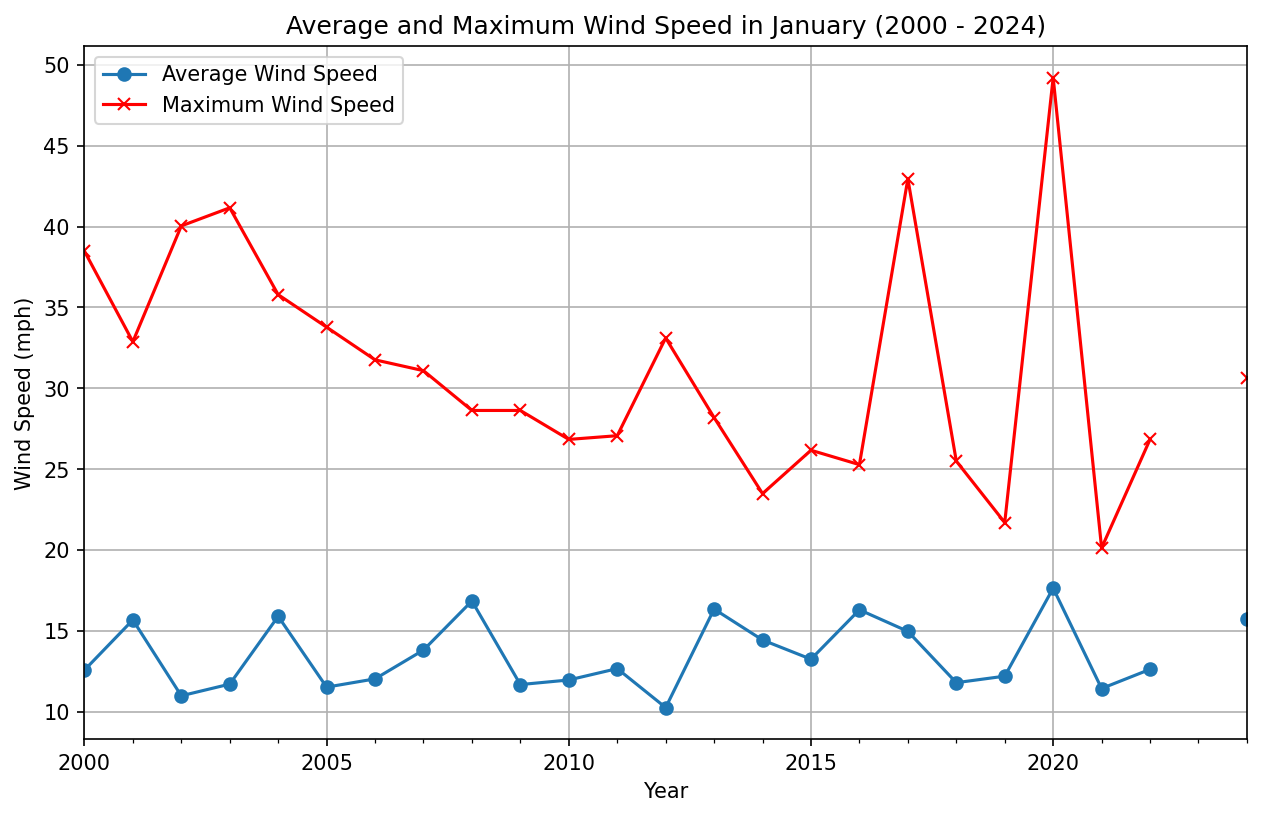

In [14]:
#Maximum and Mean Wind Speeds from 2000 for the Month of January 

data = pd.read_csv('KivalinaWeatherdata.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
january_data = data[data.index.month == 1]

##Average Wind Speed 
january_monthly_avg = january_data.resample('A')['AWND'].mean()
january_monthly_max = january_data.resample('A')['AWND'].max()
plt.figure(figsize=(10, 6))
january_monthly_avg.plot(kind='line', marker='o', label='Average Wind Speed')
january_monthly_max.plot(kind='line', marker='x', color='red', label='Maximum Wind Speed')

plt.title('Average and Maximum Wind Speed in January (2000 - 2024)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (mph)')
plt.legend()
plt.grid(True)
plt.show()



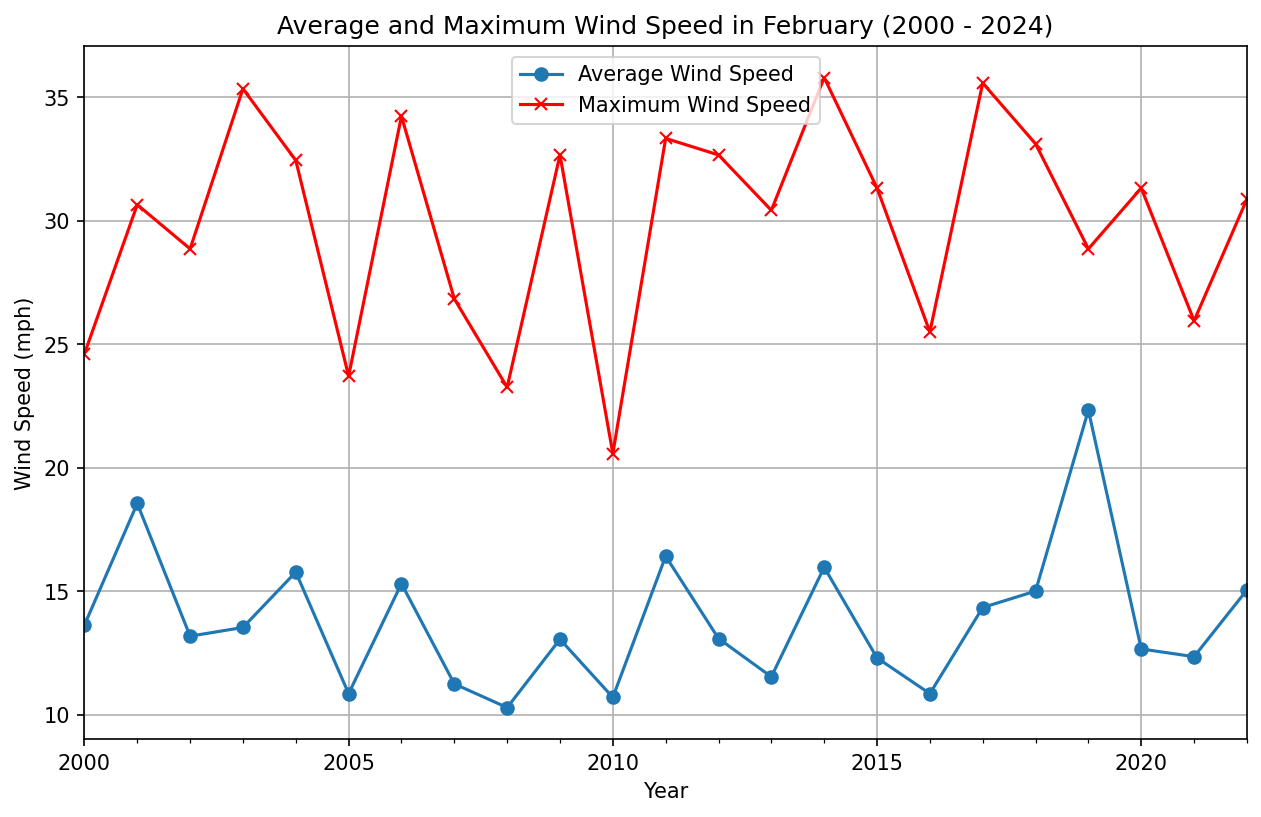

In [15]:
###Maximum and Mean Wind Speeds from 2000 for the Month of February 
february_data = data[data.index.month == 2]
february_monthly_avg = february_data.resample('A')['AWND'].mean()
february_monthly_max = february_data.resample('A')['AWND'].max()
plt.figure(figsize=(10, 6))

february_monthly_avg.plot(kind='line', marker='o', label='Average Wind Speed')
february_monthly_max.plot(kind='line', marker='x', color='red', label='Maximum Wind Speed')

plt.title('Average and Maximum Wind Speed in February (2000 - 2024)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (mph)')
plt.legend()
plt.grid(True)
plt.show()

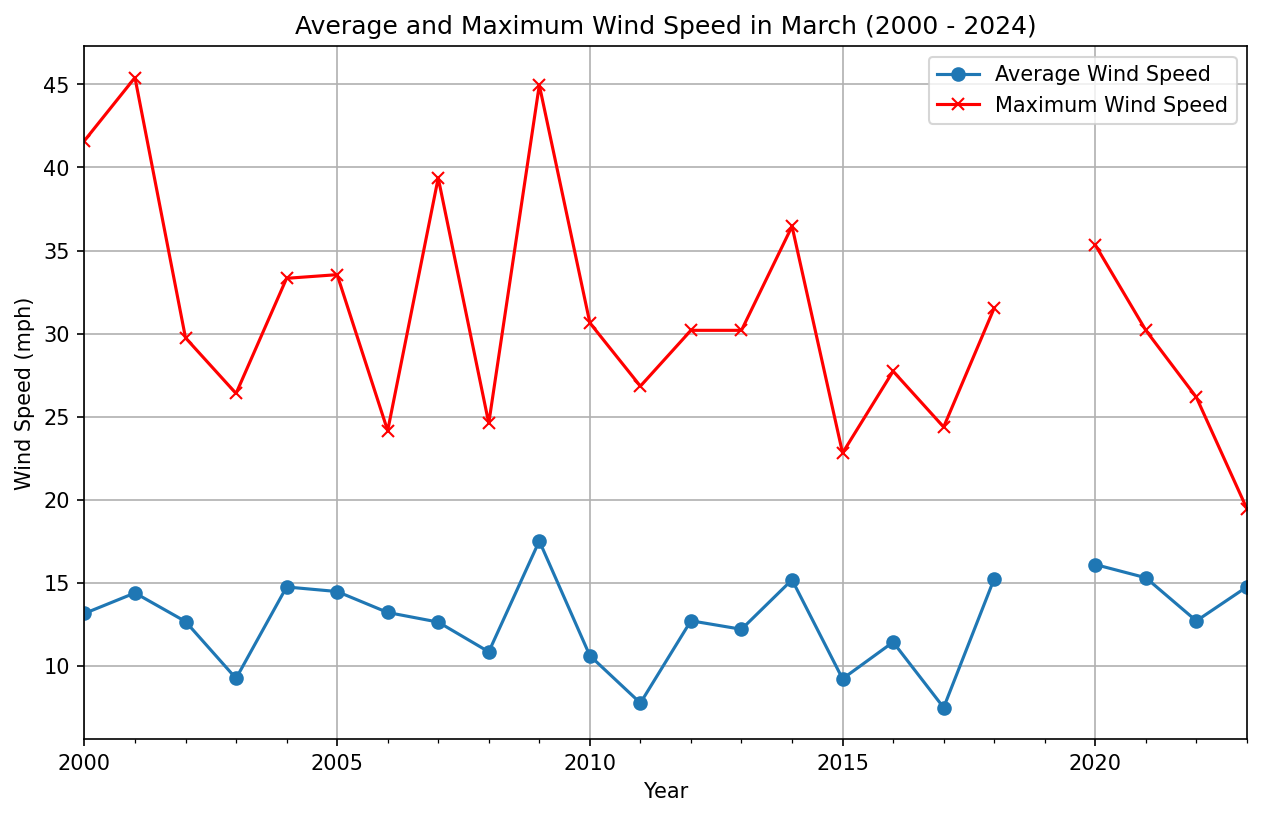

Missing Data in March:
                STATION                     NAME  LATITUDE  LONGITUDE  \
DATE                                                                    
2009-03-12  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788   
2016-03-26  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788   
2017-03-17  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788   
2018-03-08  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788   
2020-03-19  USW00026642  KIVALINA AIRPORT, AK US   67.7306 -164.54788   

            ELEVATION  AWND AWND_ATTRIBUTES  FMTM FMTM_ATTRIBUTES    PGTM  \
DATE                                                                        
2009-03-12        5.7   NaN             NaN   NaN             NaN   926.0   
2016-03-26        5.7   NaN             NaN   NaN             NaN  1633.0   
2017-03-17        5.7   NaN             NaN   NaN             NaN  1514.0   
2018-03-08        5.7   NaN             NaN   NaN             NaN   126.0   
202

In [16]:
###Maximum and Mean Wind Speeds from 2000 for the Month of March 
march_data = data[data.index.month == 3]
march_monthly_avg = march_data.resample('A')['AWND'].mean()
march_monthly_max = march_data.resample('A')['AWND'].max()
plt.figure(figsize=(10, 6))
march_monthly_avg.plot(kind='line', marker='o', label='Average Wind Speed')
march_monthly_max.plot(kind='line', marker='x', color='red', label='Maximum Wind Speed')

plt.title('Average and Maximum Wind Speed in March (2000 - 2024)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (mph)')
plt.legend()
plt.grid(True)
plt.show()
march_data = data[data.index.month == 3]
missing_data = march_data[march_data['AWND'].isnull()]
print("Missing Data in March:")
print(missing_data)

date_gaps = march_data.index.to_series().diff().sort_values(ascending=False).head()
print("\nLargest Gaps Between Dates:")
print(date_gaps)

if not date_gaps.empty:
    largest_gap = date_gaps.index[0]
    surrounding_data = march_data.loc[largest_gap - pd.Timedelta(days=5):largest_gap + pd.Timedelta(days=5)]

    print("\nData around the largest gap:")
    print(surrounding_data)


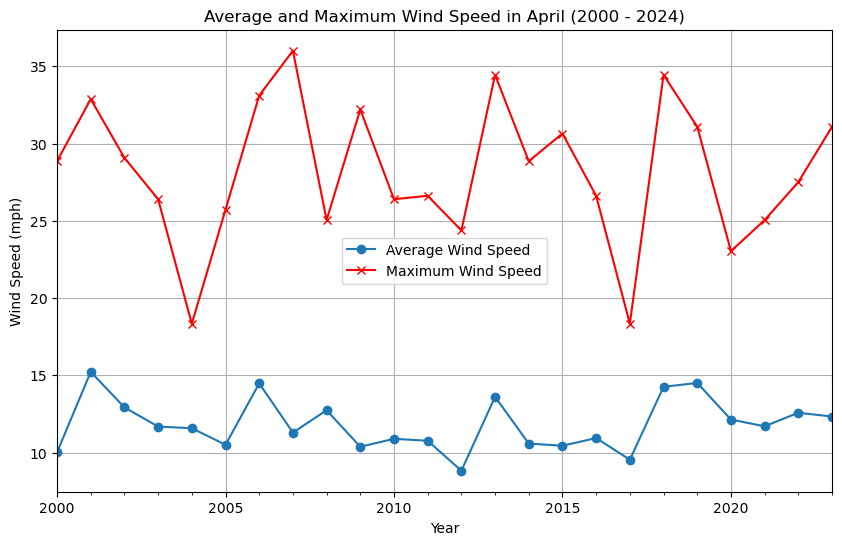

In [15]:
##Maximum and Mean Wind Speeds from 2000 for the Month of April 
april_data = data[data.index.month == 4]
april_monthly_avg = april_data.resample('A')['AWND'].mean()
april_monthly_max = april_data.resample('A')['AWND'].max()
plt.figure(figsize=(10, 6))
april_monthly_avg.plot(kind='line', marker='o', label='Average Wind Speed')
april_monthly_max.plot(kind='line', marker='x', color='red', label='Maximum Wind Speed')

plt.title('Average and Maximum Wind Speed in April (2000 - 2024)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (mph)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'april_monthly_avg' is not defined

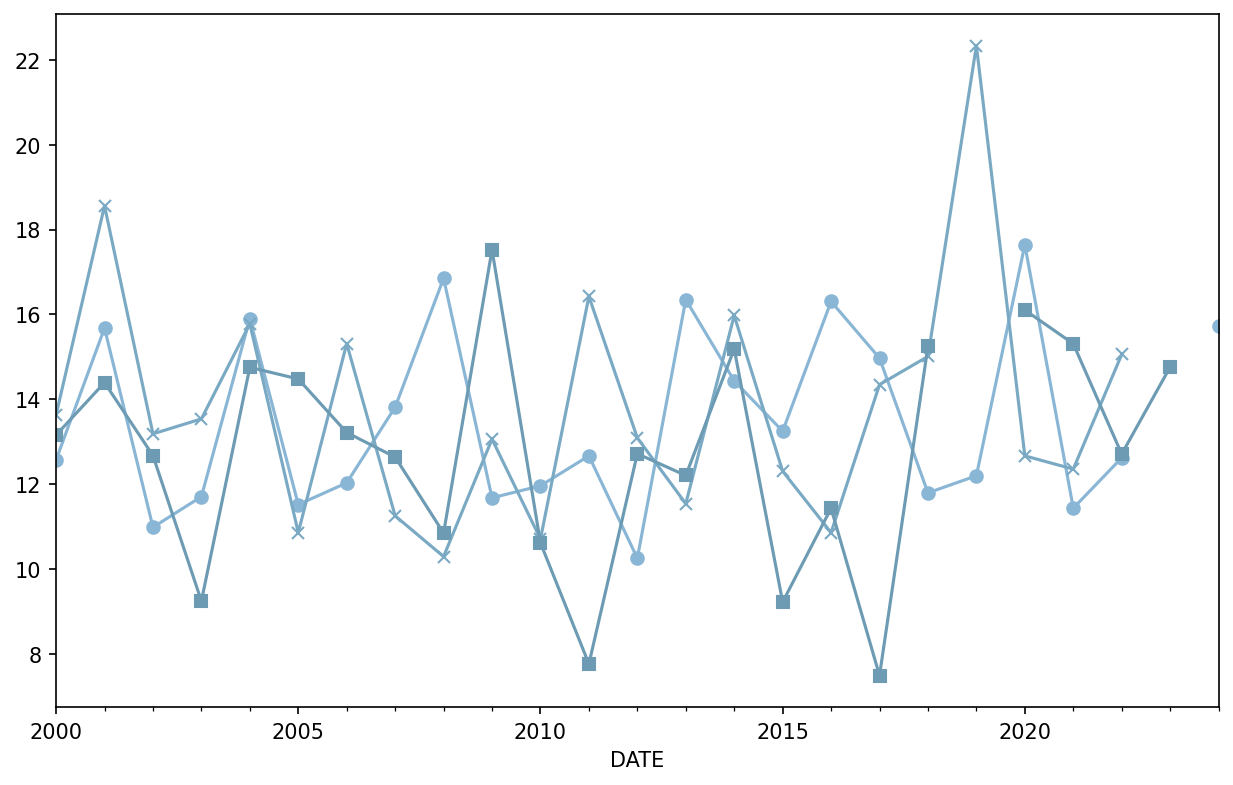

In [17]:
# All months compiled, checking for monthly predictors of later trends (i.e. do March and April, 
#the most ice-capped months, have a similar wind speed changes?) 

plt.figure(figsize=(10, 6))

# Define different shades of light blue
light_blue_palette = ['#8AB6D6', '#7AA9C4', '#6C9BB3', '#5E8EA2']

january_monthly_avg.plot(kind='line', marker='o', label='January', color=light_blue_palette[0])
february_monthly_avg.plot(kind='line', marker='x', label='February', color=light_blue_palette[1])
march_monthly_avg.plot(kind='line', marker='s', label='March', color=light_blue_palette[2])
april_monthly_avg.plot(kind='line', marker='o', label='April', color=light_blue_palette[3])

plt.title('Average Wind Speed from January to April (2000 - 2024)')
plt.xlabel('Year')
plt.ylabel('Wind Speed (mph)')
plt.legend()
plt.grid(True)
plt.show()


### Making wind plot interactive using Bokeh

In [18]:
##Making wind speeds interactive nteractive Map code works with the hovering feature 

import pandas as pd
from bokeh.plotting import figure, show, output_file
from bokeh.models import CheckboxGroup, CustomJS, HoverTool
from bokeh.layouts import column
from bokeh.io import output_notebook

data = pd.read_csv('KivalinaWeatherdata.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

def get_monthly_data(month):
    month_data = data[data.index.month == month]
    monthly_avg = month_data.resample('A')['AWND'].mean()
    monthly_max = month_data.resample('A')['AWND'].max()
    return monthly_avg.to_frame(name='AWND'), monthly_max.to_frame(name='AWND')

# Create a Bokeh plot
plot = figure(title="Wind Speed Data", x_axis_label='Year', y_axis_label='Wind Speed (mph)',
              x_axis_type='datetime', tools="pan,wheel_zoom,box_zoom,reset")

# Plot each month's data
colors = ['blue', 'green', 'red', 'purple']
legend_labels = ['January', 'February', 'March', 'April']
lines = []

for i, month in enumerate(range(1, 5)):
    avg, max = get_monthly_data(month)
    avg['type'] = 'Average'
    max['type'] = 'Maximum'
    avg['month'] = legend_labels[i]
    max['month'] = legend_labels[i]
    avg_source = ColumnDataSource(avg.reset_index())
    max_source = ColumnDataSource(max.reset_index())
    
    avg_line = plot.line('DATE', 'AWND', line_width=2, color=colors[i], legend_label=f'Avg {legend_labels[i]}', source=avg_source)
    max_line = plot.line('DATE', 'AWND', line_width=2, color=colors[i], line_dash='dashed', legend_label=f'Max {legend_labels[i]}', source=max_source)
    lines.extend([avg_line, max_line])

# Create the hover tool
hover = HoverTool(tooltips=[
    ("Type", "@type"),
    ("Month", "@month"),
    ("Date", "@DATE{%F}"),
    ("Wind Speed", "@AWND mph")
], formatters={'@DATE': 'datetime'}, mode='vline')

plot.add_tools(hover)

checkbox_group = CheckboxGroup(labels=["January", "February", "March", "April"], active=list(range(4)))
checkbox_group.js_on_click(CustomJS(args=dict(lines=lines, checkbox_group=checkbox_group), code="""
    for (var i = 0; i < lines.length; i++) {
        lines[i].visible = checkbox_group.active.includes(Math.floor(i / 2));
    }
"""))

layout = column(checkbox_group, plot)

# Show plot
output_notebook()  # To output the plot in the notebook
show(layout)


Loading BokehJS ...

### Wind Direction Exploration 
##### Wind Direction impacts movement of ice and sea ice safety as well. This is an exploratory look at the data, and mostly, for fun. 

In [74]:
##Dominant wind direction March
mar_data = data[data.index.month == 3]
mar_dominant_wind = mar_data.groupby(mar_data.index.year)['WDF2'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
dominant_wind_direction_df = pd.DataFrame({
    'Year': mar_dominant_wind.index,
    'Dominant Wind Direction': mar_dominant_wind.values
})

dominant_wind_direction_df['Cardinal Direction'] = dominant_wind_direction_df['Dominant Wind Direction'].apply(degrees_to_cardinal)

print(dominant_wind_direction_df)


    Year  Dominant Wind Direction Cardinal Direction
0   2000                     20.0                  N
1   2001                     70.0                  E
2   2002                     80.0                  E
3   2003                     20.0                  N
4   2004                     20.0                  N
5   2005                     20.0                  N
6   2006                     80.0                  E
7   2007                     30.0                 NE
8   2008                     20.0                  N
9   2009                     20.0                  N
10  2010                    310.0                 NW
11  2011                     80.0                  E
12  2012                     20.0                  N
13  2013                     20.0                  N
14  2014                     20.0                  N
15  2015                     20.0                  N
16  2016                     20.0                  N
17  2017                    340.0             

In [75]:
##Dominant wind direction April 
apr_data = data[data.index.month == 4]

apr_dominant_wind = apr_data.groupby(apr_data.index.year)['WDF2'].agg(lambda x: x.mode()[0] if not x.mode().empty else None)
dominant_wind_direction_df = pd.DataFrame({
    'Year': apr_dominant_wind.index,
    'Dominant Wind Direction': apr_dominant_wind.values
})

dominant_wind_direction_df['Cardinal Direction'] = dominant_wind_direction_df['Dominant Wind Direction'].apply(degrees_to_cardinal)

print(dominant_wind_direction_df)


    Year  Dominant Wind Direction Cardinal Direction
0   2000                     20.0                  N
1   2001                     10.0                  N
2   2002                    150.0                 SE
3   2003                     70.0                  E
4   2004                     10.0                  N
5   2005                     20.0                  N
6   2006                     10.0                  N
7   2007                     20.0                  N
8   2008                     70.0                  E
9   2009                     20.0                  N
10  2010                     20.0                  N
11  2011                     20.0                  N
12  2012                     20.0                  N
13  2013                     10.0                  N
14  2014                     20.0                  N
15  2015                     20.0                  N
16  2016                     20.0                  N
17  2017                     80.0             

# Part III: Compiling Figures into an Interactive Streamlit App 
### Keeping all data in an online repository for a more user-friendly look

In [22]:
#streamlit 
import streamlit as st
import pandas as pd
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, CheckboxGroup, CustomJS, HoverTool
from bokeh.layouts import column
data = pd.read_csv('KivalinaWeatherdata.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

def get_monthly_data(month):
    month_data = data[data.index.month == month]
    monthly_avg = month_data.resample('A')['AWND'].mean()
    monthly_max = month_data.resample('A')['AWND'].max()
    return monthly_avg.to_frame(name='AWND'), monthly_max.to_frame(name='AWND')

plot = figure(title="Wind Speed Data", x_axis_label='Year', y_axis_label='Wind Speed (mph)',
              x_axis_type='datetime', tools="pan,wheel_zoom,box_zoom,reset")

colors = ['blue', 'green', 'red', 'purple']
legend_labels = ['January', 'February', 'March', 'April']
lines = []

for i, month in enumerate(range(1, 5)):
    avg, max = get_monthly_data(month)
    avg['type'] = 'Average'
    max['type'] = 'Maximum'
    avg['month'] = legend_labels[i]
    max['month'] = legend_labels[i]
    avg_source = ColumnDataSource(avg.reset_index())
    max_source = ColumnDataSource(max.reset_index())
    
    avg_line = plot.line('DATE', 'AWND', line_width=2, color=colors[i], legend_label=f'Avg {legend_labels[i]}', source=avg_source)
    max_line = plot.line('DATE', 'AWND', line_width=2, color=colors[i], line_dash='dashed', legend_label=f'Max {legend_labels[i]}', source=max_source)
    lines.extend([avg_line, max_line])

hover = HoverTool(tooltips=[
    ("Type", "@type"),
    ("Month", "@month"),
    ("Date", "@DATE{%F}"),
    ("Wind Speed", "@AWND mph")
], formatters={'@DATE': 'datetime'}, mode='vline')

plot.add_tools(hover)

checkbox_group = CheckboxGroup(labels=["January", "February", "March", "April"], active=list(range(4)))
checkbox_group.js_on_click(CustomJS(args=dict(lines=lines, checkbox_group=checkbox_group), code="""
    for (var i = 0; i < lines.length; i++) {
        lines[i].visible = checkbox_group.active.includes(Math.floor(i / 2));
    }
"""))

layout = column(checkbox_group, plot)

st.bokeh_chart(layout)


DeltaGenerator()

In [ ]:
! pip install streamlit
! streamlit run app3.py